In [2]:
# Yile Shen
# 3/7/2024
# Advanced Programming: AIML
# Osu playing robot

# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import math

from tqdm import tqdm

# couple notes: i chose to switch to pytorch as I was more comfortable with it
# and I needed to customize my model in a lot of ways, and I couldn't
# adequately get tensorflow to work.

# I also already had a really good setup for pytorch and I spent more time
# tuning the gpu usage on tensorflow. Pytorch also saved WAY more memory overall.

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

# print name
print(torch.cuda.get_device_name(device))

# i had a tensorflow version, but I couldn't get some things to work in it
# so I switched to pytorch because I'm more comfortable with it and can do more.

#process images here so I can change resolution whenever
#
# FOLDER_PATH = "C:/Users/Yile0/PycharmProjects/osutime/frames/"
#
# for i in range(14, 5379):
#     img = cv2.imread(FOLDER_PATH + str(i)+".png")
#     img = cv2.resize(img, (160, 120), interpolation=cv2.INTER_AREA)
#     cv2.imwrite(FOLDER_PATH + str(i)+".png", img)
# making a custom image dataset class for pytorch
# originally had a custom dataset maker, but the dataloader is way better
# and formats them better.



NVIDIA GeForce RTX 3070


In [3]:
# compile dataset.
dataset_path = "C:/Users/Yile0/PycharmProjects/osutime/map1_data.csv"
data = pd.read_csv(dataset_path)

print(data.head())
print(data.columns)
# small data for changing, basically just for trialing new changes.
small_data = sklearn.utils.resample(data, n_samples= 1000)

# frame 4 is the latest/ most recent.

#originally these were one piece, changed for the dataloader to function
processed_data = []
processed_labels = []


def process_img(paths):
    # I had another self-made thing here that I decided to replace with premade functions
    images = []
    transform = transforms.Compose([transforms.ToTensor()])
    for path in paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        # 100 by 75 because slightly better quality
        # over 80 by 60
        img = cv2.resize(img, (120, 68), interpolation=cv2.INTER_AREA)
        img_normalized = cv2.normalize(img, None, 0, 1.0,
                                       cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        images.append(transform(img_normalized))
    out = torch.stack(images)
    # i played with trying to reshape to 120 16, but I came back
    # to this resolution because it was just so much better and faster
    # with regards to my training speed.
    out = out.reshape(len(paths),68,120)
    # played with preloading here and loading later, seems like loading later is better.
    # img = torch.from_numpy(img)
    return out


for index, row in tqdm(data.iterrows()):
    # trying without normalization.
    processed_labels.append([row['x'], row['y']])
    # try to predict just on 1 frame for testing
    processed_data.append(process_img([row['frame 4'],row['frame 3'],row['frame 2'],row['frame 1']]))


X_train, X_test, y_train, y_test = train_test_split(processed_data, processed_labels, test_size=0.2, random_state=39)

          x         y                                            frame 4  \
0  253.3333  256.4445  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
1  253.3333  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
2  252.8889  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
3  252.8889  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
4  252.8889  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   

                                             frame 3  \
0  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
1  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
2  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
3  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
4  C:/Users/Yile0/PycharmProjects/osutime/frames/...   

                                             frame 2  \
0  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
1  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
2  C:/Users/Yile0/PycharmProjects/osut

8930it [01:59, 74.63it/s]


In [4]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, imageTransform=None, num_workers=0):
        self.imageTransform = imageTransform
        self.num_workers = num_workers
        self.imgs = images
        self.targets = labels

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        image = self.imgs[idx]
        target = self.targets[idx]
        label = torch.Tensor(target)

        return image, label

In [5]:
# Creating a CNN class
# conv neural net combined was bad, this iteration separates them
class ConvNeuralNet(nn.Module):
    #  Determine what layers and their order in CNN object
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        # adjusted the first pooling to be 4 instead.
        # tried second pooling to be 4 too

        self.conv_layer1 = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=4)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4)
        self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_layer4 = nn.Conv2d(in_channels=512, out_channels=64, kernel_size=4)
        self.max_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten(1)
        self.fc1 = nn.Linear(24192, 128)
        # originally tried relu layers, but wanted something non-linear
        # went back because elu wasn't doing better
        # had 3 layers to begin with, then tried 4, then tried 7
        # I one off tried 13 but it didn't fit.=
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128, 2)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 2)
        # self.relu7 = nn.ReLU()
        # self.fc8 = nn.Linear(75, 1)
        # self.relu8 = nn.ReLU()
        # self.fc9 = nn.Linear(25, 1)
        # self.relu9 = nn.ReLU()
        # self.fc10 = nn.Linear(50, 1)
        self.mult = torch.tensor([512,384])
        self.mult = self.mult.to(device)
    # Progresses data across layers
    def forward(self, input):
        out_x = self.conv_layer1(input)
        out_x = self.relu(out_x)
        out_x = self.max_pool1(out_x)
        out_x = self.conv_layer2(out_x)
        out_x = self.relu(out_x)
        out_x = self.max_pool2(out_x)

        # out_x = self.conv_layer3(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.max_pool3(out_x)
        # out_x = self.conv_layer4(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.max_pool4(out_x)

        out_x = self.flatten(out_x)
        
        out_x = self.fc1(out_x)
        out_x = self.sigmoid(out_x)
        out_x = self.fc2(out_x)
        out_x = self.sigmoid(out_x)
        out_x = self.fc3(out_x)
        out_x = self.sigmoid(out_x)
        out_x = out_x * self.mult
        # 
        # out_x = self.sigmoid(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.relu(out_x)

        return out_x

In [6]:
# Define relevant variables for the ML task
# tried batch sizes of 32 and 128 as well, but this was best
# 128 had better cuda utilization but didn't boost speed too much.
# decided it was more worth it to have better accuracy because 128 could
# introduce inaccuracies.
# after adding a few new layers 64 wasn't enough to have fast epochs
# so I decided to move to 128.
# accidentally tried batch size of 1, was way too inefficient
batch_size = 80
# originally learning rate was 0.001, but im making it learn longer and slower.
# makes me wonder if my original idea would have worked, but now it's too late to fix it.
# 0.001 basically didn't learn. I trained for somwhere around 500 epochs and loss basiclly didn't change
# from now on, I ran some 20 epoch experiments.
# 0.0001 was learning a lot to start, but loss seems to cycle between 0.10 and 0.13 or so

# 0.00001 had loss settle at around 0.28/0.3, which is maybe due to the lack of time it had to train.
# loss was generally going down even at 50 epochs, can't tell without a longer experiment.
# i'm going to keep it at this and train for 100 and see what happens.
# doesn't seem to improve past loss = 0.11

# running a 400 epoch experiment with learning rate 0.000001
learning_rate = 0.000001
# ran a few experiments on 20 epochs to see if it would learn.
num_epochs = 1500

In [7]:
dataset = ImageDataset(X_train, y_train)
test = ImageDataset(X_test, y_test)

# added workers to speedup epoch time.
# 3 is the max tolerable it seems.
data_loader = DataLoader(dataset, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)

print(X_train[0].shape)

# model = ConvNeuralNet(2, train_data.shape[0])

# Set Loss function with criterion

model = ConvNeuralNet(2)
model.cuda(device)
# adam is just better, tried other optimizers like sgd though
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# MSE loss instead of L1, which is squared loss vs linear loss.
# Huber over both, has the benefits of both.
criterion = nn.MSELoss()
epoch_start = 0


epoch_start = 0
# added code that allows it to train again from a checkpoint
# it lets me train in chunks over time.
checkpoint = torch.load('model_duo.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_start = checkpoint['epoch']
loss = checkpoint['loss']

# Set optimizer with optimizer

total_step = len(processed_data)

model.train()

losses = []
losses_val = []


torch.Size([4, 68, 120])


C:\Users\Yile0\AppData\Local\Temp\ipykernel_34696\181565771.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_duo.pth')


In [8]:
import gc
def main():
    gc.collect()
    torch.cuda.empty_cache()
    for epoch in tqdm(range(epoch_start, epoch_start + num_epochs)):
        start = time.time()
        model.train()
        # Load in the data in batches using the train_loader object
        for i, (images, labels) in enumerate(data_loader):
            images = images.to(device)
            # Move tensors to the configured device
            # images already got loaded on
            # images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            output = model(images)
            # process into the separate multipliers. 
            
            loss = criterion(output, labels)
            # had tried to combined, but now i'm just completely
            # separating the two models.
            loss.backward()
            optimizer.step()
        # added checkpoint saver
        if (epoch + 1) % 6 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
            }, "model_duo.pth")
        model.eval()
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            # Move tensors to the configured device
            # images already got loaded on
            # images = images.to(device)
            output = model(images)
            # process into the separate multipliers. 
            loss_valid = criterion(output, labels)
            
        print('val')
        print(labels)
        print(output)

        # step lr scheduler
        # add so I can graph later
        losses.append(loss.item())
        losses_val.append(loss_valid.item())
        print('validate Loss_X: {:.10f}'.format(loss_valid.item()))

        end = time.time()
        print('Epoch [{}/{}], Loss1: {:.10f}, Time: {:.10f}'.format(epoch + 1, num_epochs + epoch_start, loss.item(), end-start))

    # torch.save({
    #                 'epoch': num_epochs,
    #                 'model_x_state_dict': model_x.state_dict(),
    #                 'optimizer_x_state_dict': optimizer_x.state_dict(),
    #                 'model_y_state_dict': model_y.state_dict(),
    #                 'optimizer_y_state_dict': optimizer_y.state_dict(),
    #                 'loss': criterion,
    #             }, "model.pth")
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
            }, "model_duo.pth")


if __name__ == '__main__':
    main()

  0%|          | 1/1500 [00:02<1:00:17,  2.41s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.8379,  84.2752],
        [362.5393, 167.0769],
        [233.0556, 147.0914],
        [344.7763,  81.9199],
        [175.3031, 289.7827],
        [234.0163,  78.0936],
        [238.7001,

  0%|          | 2/1500 [00:03<47:17,  1.89s/it]  

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.7452,  84.4848],
        [362.4640, 167.3979],
        [232.9330, 147.3960],
        [344.6842,  82.1226],
        [175.2424, 290.0170],
        [233.9169,  78.2874],
        [238.6075,

  0%|          | 3/1500 [00:05<42:10,  1.69s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.2103,  84.7159],
        [361.9684, 167.7300],
        [232.3492, 147.7102],
        [344.1626,  82.3413],
        [174.7422, 290.2520],
        [233.3431,  78.4989],
        [238.0191,

  0%|          | 4/1500 [00:06<39:45,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.6179,  84.8507],
        [361.4043, 167.9097],
        [231.6944, 147.8797],
        [343.5788,  82.4654],
        [174.1705, 290.3731],
        [232.7053,  78.6206],
        [237.3568,

  0%|          | 5/1500 [00:08<38:22,  1.54s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.3755,  84.8296],
        [361.1544, 167.8651],
        [231.5498, 147.8313],
        [343.3258,  82.4404],
        [173.9261, 290.3341],
        [232.4394,  78.5992],
        [237.0733,

  0%|          | 6/1500 [00:09<37:33,  1.51s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.6648,  84.6729],
        [361.3952, 167.6363],
        [231.8135, 147.6137],
        [343.5807,  82.2876],
        [174.1934, 290.1679],
        [232.7406,  78.4542],
        [237.3741,

  0%|          | 7/1500 [00:11<37:01,  1.49s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.3751,  84.4494],
        [362.0266, 167.3239],
        [232.4654, 147.3189],
        [344.2379,  82.0727],
        [174.8705, 289.9472],
        [233.4911,  78.2489],
        [238.1396,

  1%|          | 8/1500 [00:12<37:08,  1.49s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.9691,  84.2418],
        [362.5454, 167.0307],
        [233.0864, 147.0386],
        [344.7805,  81.8718],
        [175.4319, 289.7395],
        [234.1174,  78.0578],
        [238.7736,

  1%|          | 9/1500 [00:14<36:45,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.9768,  84.1492],
        [362.5170, 166.8891],
        [233.0657, 146.9012],
        [344.7592,  81.7775],
        [175.4227, 289.6346],
        [234.1182,  77.9708],
        [238.7572,

  1%|          | 10/1500 [00:15<36:27,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.4495,  84.2592],
        [361.9998, 167.0386],
        [232.4676, 147.0388],
        [344.2266,  81.8762],
        [174.9077, 289.7371],
        [233.5513,  78.0694],
        [238.1555,

  1%|          | 11/1500 [00:17<36:16,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.8762,  84.5531],
        [361.4530, 167.4735],
        [231.8391, 147.4451],
        [343.6514,  82.1543],
        [174.3719, 290.0498],
        [232.9385,  78.3387],
        [237.5137,

  1%|          | 12/1500 [00:18<36:07,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.6391,  84.8664],
        [361.2235, 167.9541],
        [231.5877, 147.8939],
        [343.3981,  82.4542],
        [174.1727, 290.4009],
        [232.6858,  78.6276],
        [237.2474,

  1%|          | 13/1500 [00:19<36:01,  1.45s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.8016,  84.9693],
        [361.3502, 168.1273],
        [231.7501, 148.0517],
        [343.5226,  82.5514],
        [174.3406, 290.5322],
        [232.8570,  78.7226],
        [237.4108,

  1%|          | 14/1500 [00:21<36:15,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.2244,  84.7351],
        [361.6889, 167.7915],
        [232.1677, 147.7279],
        [343.8880,  82.3203],
        [174.7174, 290.2953],
        [233.2876,  78.5076],
        [237.8390,

  1%|          | 15/1500 [00:22<36:06,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.6563,  84.2900],
        [362.0134, 167.1283],
        [232.5729, 147.0952],
        [344.2549,  81.8814],
        [175.0705, 289.8181],
        [233.7438,  78.0929],
        [238.2601,

  1%|          | 16/1500 [00:24<35:59,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.8019,  83.9321],
        [362.0742, 166.5879],
        [232.6684, 146.5783],
        [344.3471,  81.5249],
        [175.1498, 289.4265],
        [233.8973,  77.7574],
        [238.3662,

  1%|          | 17/1500 [00:25<35:53,  1.45s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.5678,  83.9411],
        [361.8098, 166.6049],
        [232.3746, 146.5864],
        [344.0814,  81.5250],
        [174.9044, 289.4407],
        [233.6324,  77.7647],
        [238.0736,

  1%|          | 18/1500 [00:27<35:50,  1.45s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.2152,  84.3704],
        [361.4722, 167.2736],
        [231.9953, 147.2077],
        [343.7106,  81.9372],
        [174.6022, 289.9344],
        [221.7321,  80.1237],
        [237.6780,

  1%|▏         | 19/1500 [00:28<35:48,  1.45s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.2651,  84.8887],
        [361.5256, 168.0973],
        [232.0753, 147.9743],
        [343.7329,  82.4402],
        [174.7119, 290.5476],
        [207.2282,  83.2051],
        [237.7384,

  1%|▏         | 20/1500 [00:30<36:04,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.6420,  85.0445],
        [361.8563, 168.3763],
        [232.4917, 148.2263],
        [344.0657,  82.5899],
        [175.0911, 290.7692],
        [233.7478,  78.7839],
        [238.1376,

  1%|▏         | 21/1500 [00:31<35:56,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.6878,  84.6684],
        [361.8255, 167.8221],
        [232.4588, 147.6924],
        [344.0682,  82.2136],
        [175.0589, 290.3819],
        [233.8040,  78.4297],
        [238.1277,

  1%|▏         | 22/1500 [00:33<35:51,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.3702,  84.0336],
        [361.4319, 166.8541],
        [232.0040, 146.7676],
        [343.7174,  81.5802],
        [174.6269, 289.6868],
        [233.3252,  77.8560],
        [237.6949,

  2%|▏         | 23/1500 [00:34<35:47,  1.45s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.4107,  83.6244],
        [361.3963, 166.2487],
        [231.9722, 146.1863],
        [343.7179,  81.1691],
        [174.5754, 289.2642],
        [233.2696,  77.4878],
        [237.6769,

  2%|▏         | 24/1500 [00:35<35:45,  1.45s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.9409,  83.7688],
        [361.8681, 166.5210],
        [232.5408, 146.4344],
        [344.2008,  81.3028],
        [175.0776, 289.4992],
        [234.0957,  77.5795],
        [238.2423,

  2%|▏         | 25/1500 [00:37<35:43,  1.45s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.0354,  84.3657],
        [361.9693, 167.4750],
        [232.6725, 147.3240],
        [344.2736,  81.8779],
        [175.2079, 290.2275],
        [234.2181,  78.1317],
        [238.3548,

  2%|▏         | 26/1500 [00:38<35:58,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.5179,  84.9440],
        [361.4937, 168.3723],
        [232.1212, 148.1591],
        [343.7566,  82.4310],
        [174.7276, 290.9020],
        [223.2014,  80.4601],
        [237.7847,

  2%|▏         | 27/1500 [00:40<35:50,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.2440,  85.0122],
        [361.2040, 168.4967],
        [231.7870, 148.2648],
        [343.4644,  82.4838],
        [174.4126, 291.0208],
        [233.4319,  78.7159],
        [237.4497,

  2%|▏         | 28/1500 [00:41<35:45,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.9395,  84.4931],
        [361.7792, 167.7571],
        [232.4695, 147.5578],
        [344.0977,  81.9634],
        [174.9657, 290.5326],
        [234.1924,  78.2277],
        [238.1530,

  2%|▏         | 29/1500 [00:43<35:40,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[184.0874,  83.8368],
        [362.7620, 166.8160],
        [233.6356, 146.6649],
        [345.1582,  81.3085],
        [175.9362, 289.9053],
        [235.4293,  77.6141],
        [239.3467,

  2%|▏         | 30/1500 [00:44<35:37,  1.45s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[184.5550,  83.5301],
        [363.1339, 166.3848],
        [234.0804, 146.2528],
        [345.5705,  80.9912],
        [176.2740, 289.6417],
        [235.9469,  77.3220],
        [239.8066,

  2%|▏         | 31/1500 [00:46<35:35,  1.45s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.6298,  83.7562],
        [362.2501, 166.7263],
        [233.0375, 146.5646],
        [344.6611,  81.1877],
        [175.3084, 289.9233],
        [234.9904,  77.5175],
        [238.7580,

  2%|▏         | 32/1500 [00:47<35:50,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.2839,  84.3035],
        [360.9966, 167.5509],
        [231.5645, 147.3298],
        [343.3499,  81.6976],
        [173.9732, 290.5518],
        [233.5882,  78.0104],
        [237.2647,

  2%|▏         | 33/1500 [00:49<35:43,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.8872,  84.7688],
        [360.6309, 168.2850],
        [231.1320, 148.0117],
        [342.9493,  82.1329],
        [173.5673, 291.1268],
        [233.1995,  78.4325],
        [236.8229,

  2%|▏         | 34/1500 [00:50<35:37,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.0754,  84.7146],
        [361.7208, 168.2816],
        [232.4151, 147.9998],
        [344.0687,  82.0674],
        [174.6626, 291.1892],
        [179.9596,  88.4923],
        [238.1117,

  2%|▏         | 35/1500 [00:51<35:34,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[184.7593,  84.0108],
        [363.2170, 167.2985],
        [234.1821, 147.0638],
        [345.6419,  81.3680],
        [176.1655, 290.5466],
        [176.8525,  88.7732],
        [239.9048,

  2%|▏         | 36/1500 [00:53<35:32,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[185.0233,  83.1065],
        [363.3738, 165.9475],
        [234.3571, 145.7786],
        [345.8553,  80.4637],
        [176.2368, 289.6118],
        [177.1123,  87.8592],
        [240.1068,

  2%|▏         | 37/1500 [00:54<35:29,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.5344,  82.6998],
        [361.9482, 165.3064],
        [232.6381, 145.1562],
        [344.4178,  80.0392],
        [174.6417, 289.1738],
        [175.7155,  87.4359],
        [238.4018,

  3%|▎         | 38/1500 [00:56<35:45,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.9750,  83.2154],
        [360.5224, 166.0979],
        [230.9349, 145.8837],
        [342.9205,  80.5183],
        [173.0940, 289.7947],
        [174.5061,  87.8989],
        [236.6808,

  3%|▎         | 39/1500 [00:57<35:36,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.9193,  84.3650],
        [360.5517, 167.9078],
        [230.9590, 147.5815],
        [342.8693,  81.6239],
        [173.0986, 291.1759],
        [177.2549,  88.4877],
        [236.6735,

  3%|▎         | 40/1500 [00:59<35:33,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.3285,  85.2598],
        [361.9221, 169.3507],
        [232.5767, 148.9447],
        [344.2124,  82.4842],
        [174.5006, 292.2914],
        [234.9798,  78.8287],
        [238.2739,

  3%|▎         | 41/1500 [01:00<35:28,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[184.5678,  85.1547],
        [363.0638, 169.2758],
        [233.9139, 148.8625],
        [345.3767,  82.3704],
        [236.1967, 280.9215],
        [236.3437,  78.7268],
        [239.6188,

  3%|▎         | 42/1500 [01:02<35:25,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[184.0247,  84.0542],
        [362.5033, 167.6451],
        [233.1959, 147.2881],
        [344.8445,  81.2832],
        [306.1620, 260.6127],
        [235.7798,  77.6888],
        [238.9268,

  3%|▎         | 43/1500 [01:03<35:21,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.0108,  82.8780],
        [360.5775, 165.8478],
        [230.8501, 145.5488],
        [342.9149,  80.1205],
        [308.3107, 257.7394],
        [233.6370,  76.5723],
        [236.6000,

  3%|▎         | 44/1500 [01:05<35:36,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.6524,  82.3805],
        [359.2947, 165.1014],
        [229.2897, 144.8098],
        [341.6089,  79.6209],
        [317.9811, 253.7382],
        [232.2088,  76.0919],
        [235.0412,

  3%|▎         | 45/1500 [01:06<35:29,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.8048,  82.8177],
        [360.4196, 165.8569],
        [230.5932, 145.5079],
        [342.7169,  80.0362],
        [319.3350, 254.3864],
        [233.5016,  76.4962],
        [236.3340,

  3%|▎         | 46/1500 [01:08<35:25,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[184.6825,  83.8095],
        [363.1452, 167.4904],
        [233.8372, 147.0554],
        [345.4460,  80.9921],
        [275.7487, 266.0232],
        [236.6483,  77.4265],
        [239.5634,

  3%|▎         | 47/1500 [01:09<35:24,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[186.5607,  84.7364],
        [364.9158, 168.9839],
        [235.9624, 148.4673],
        [347.2071,  81.8813],
        [261.4222, 270.6591],
        [238.7174,  78.2901],
        [241.6705,

  3%|▎         | 48/1500 [01:10<35:20,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[185.8065,  85.1809],
        [364.2867, 169.6919],
        [235.1638, 149.1067],
        [346.4636,  82.3235],
        [273.0598, 268.7602],
        [237.9757,  78.6887],
        [240.8504,

  3%|▎         | 49/1500 [01:12<35:18,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.1820,  84.8333],
        [361.9139, 169.1723],
        [232.2440, 148.5596],
        [340.6331,  83.3617],
        [311.0395, 259.6536],
        [235.2163,  78.3386],
        [237.9174,

  3%|▎         | 50/1500 [01:13<35:33,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.3015,  83.8115],
        [360.1656, 167.6454],
        [230.0787, 147.0653],
        [342.3021,  80.9421],
        [316.9414, 256.5098],
        [233.2241,  77.3639],
        [235.7579,

  3%|▎         | 51/1500 [01:15<35:24,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.8910,  82.5660],
        [360.6925, 165.8198],
        [231.0554, 145.2972],
        [342.8788,  79.7194],
        [319.0900, 254.5031],
        [233.8720,  76.1960],
        [236.3217,

  3%|▎         | 52/1500 [01:16<35:17,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[184.1710,  81.8445],
        [362.7953, 164.8228],
        [335.4909, 140.5412],
        [345.0426,  79.0110],
        [321.3132, 253.6327],
        [236.3380,  75.5277],
        [238.7855,

  4%|▎         | 53/1500 [01:18<35:14,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[185.9218,  82.1128],
        [364.4413, 165.3340],
        [337.3056, 141.0080],
        [346.6900,  79.2639],
        [259.6920, 267.8610],
        [237.7296,  75.8671],
        [240.7159,

  4%|▎         | 54/1500 [01:19<35:09,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[185.4769,  83.2373],
        [364.1368, 167.1033],
        [324.2121, 143.1725],
        [346.2902,  80.3452],
        [259.0248, 269.4283],
        [178.1981,  87.9471],
        [240.2758,

  4%|▎         | 55/1500 [01:21<35:06,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.3168,  84.4057],
        [362.2733, 168.8939],
        [234.0083, 148.0655],
        [344.2797,  81.4694],
        [256.6893, 270.9480],
        [176.1696,  89.1235],
        [237.9424,

  4%|▎         | 56/1500 [01:22<35:20,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.1811,  84.8464],
        [360.3769, 169.5819],
        [230.6980, 148.7053],
        [340.8548,  82.4594],
        [254.3200, 271.5376],
        [174.1563,  89.5598],
        [235.5867,

  4%|▍         | 57/1500 [01:24<35:11,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.5906,  84.2670],
        [359.8565, 168.7613],
        [257.1914, 146.9361],
        [321.7741,  89.3765],
        [253.5706, 270.8788],
        [187.7287,  86.0469],
        [234.8897,

  4%|▍         | 58/1500 [01:25<35:05,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.0142,  82.9978],
        [361.1730, 166.9261],
        [232.4082, 146.0840],
        [339.0228,  81.6935],
        [254.9876, 269.3757],
        [234.2691,  76.5591],
        [236.3945,

  4%|▍         | 59/1500 [01:27<35:00,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[184.4902,  81.8173],
        [363.4424, 165.2310],
        [233.4399, 144.5145],
        [345.3560,  78.9648],
        [257.5437, 267.9872],
        [236.9290,  75.4691],
        [239.0651,

  4%|▍         | 60/1500 [01:28<34:55,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[186.5036,  81.3008],
        [365.2971, 164.5425],
        [235.6262, 143.8413],
        [347.2504,  78.4581],
        [259.6477, 267.4430],
        [239.0524,  75.0049],
        [241.2537,

  4%|▍         | 61/1500 [01:29<34:52,  1.45s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[186.6861,  81.6923],
        [365.5654, 165.2099],
        [235.9102, 144.4393],
        [347.4460,  78.8331],
        [259.8686, 268.0401],
        [180.2546,  86.2439],
        [241.5209,

  4%|▍         | 62/1500 [01:31<35:06,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.7818,  83.1316],
        [363.9399, 166.8450],
        [233.9018, 145.9426],
        [345.6617,  79.8455],
        [257.8152, 269.4393],
        [177.7794,  87.4445],
        [288.4412,

  4%|▍         | 63/1500 [01:32<35:01,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.1516,  84.8232],
        [361.5581, 168.5215],
        [230.9972, 147.4852],
        [343.1022,  80.9017],
        [254.8636, 270.8563],
        [175.2216,  88.5478],
        [236.4808,

  4%|▍         | 64/1500 [01:34<34:55,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.1199,  84.5325],
        [360.0148, 169.5617],
        [229.1676, 148.4277],
        [341.4224,  81.5493],
        [252.9131, 271.7370],
        [200.0345,  83.8700],
        [234.5503,

  4%|▍         | 65/1500 [01:35<34:52,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.4596,  84.4689],
        [360.2381, 169.5788],
        [229.3172, 148.4100],
        [341.5794,  81.5242],
        [253.0439, 271.7737],
        [231.8049,  78.1150],
        [234.7383,

  4%|▍         | 66/1500 [01:37<34:53,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.6599,  84.6676],
        [362.0860, 168.5090],
        [231.4575, 147.3656],
        [343.4337,  80.7879],
        [255.0728, 270.9171],
        [176.3783,  88.2903],
        [236.8836,

  4%|▍         | 67/1500 [01:38<34:51,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[130.9225,  94.8220],
        [364.2838, 166.7521],
        [234.0363, 145.6741],
        [345.6748,  79.6204],
        [257.5324, 269.4764],
        [177.9823,  87.2274],
        [239.4819,

  5%|▍         | 68/1500 [01:40<35:10,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[131.8427,  93.5647],
        [365.5022, 164.9615],
        [235.4475, 143.9508],
        [346.9167,  78.4577],
        [258.8226, 267.9840],
        [179.3111,  86.0127],
        [240.9170,

  5%|▍         | 69/1500 [01:41<35:01,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[131.6225,  92.7882],
        [365.2561, 163.8819],
        [235.0863, 142.8961],
        [346.6294,  77.7670],
        [258.3520, 267.0752],
        [179.0637,  85.2903],
        [240.5573,

  5%|▍         | 70/1500 [01:43<34:54,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[131.3908,  92.6974],
        [363.8586, 164.1620],
        [233.3394, 143.1198],
        [345.1084,  77.9373],
        [256.5133, 267.3205],
        [177.5509,  85.4699],
        [238.7729,

  5%|▍         | 71/1500 [01:44<34:48,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.0936,  81.8879],
        [362.2628, 165.8376],
        [231.3720, 144.6630],
        [343.3330,  78.9800],
        [254.4682, 268.7553],
        [175.7934,  86.5673],
        [236.7502,

  5%|▍         | 72/1500 [01:46<34:45,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.5532,  83.3205],
        [361.5198, 168.2072],
        [230.4376, 146.8741],
        [342.4062,  80.4576],
        [253.4612, 270.7669],
        [174.9621,  88.1129],
        [235.7524,

  5%|▍         | 73/1500 [01:47<34:41,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.8660,  84.5997],
        [361.9384, 170.2109],
        [230.8962, 148.7514],
        [342.6856,  81.7067],
        [253.8378, 272.4543],
        [232.8825,  78.4069],
        [236.1592,

  5%|▍         | 74/1500 [01:49<34:56,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.9814,  85.0450],
        [363.0364, 170.9462],
        [232.1691, 149.4277],
        [343.7112,  82.1486],
        [255.0145, 273.0814],
        [235.7699,  78.5499],
        [237.4044,

  5%|▌         | 75/1500 [01:50<34:47,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.9954,  84.3389],
        [363.9611, 169.9250],
        [233.2280, 148.4294],
        [344.6241,  81.4743],
        [255.9670, 272.2517],
        [228.8586,  79.2996],
        [238.4648,

  5%|▌         | 76/1500 [01:51<34:39,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[184.4351,  82.7854],
        [364.3029, 167.5796],
        [233.5732, 146.1726],
        [344.9884,  79.9768],
        [256.2020, 270.3018],
        [194.2431,  84.3041],
        [238.8343,

  5%|▌         | 77/1500 [01:53<34:35,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[184.3406,  81.1594],
        [364.1547, 165.0836],
        [233.3186, 143.7782],
        [344.8542,  78.4076],
        [255.8449, 268.1935],
        [236.8134,  75.0179],
        [238.6066,

  5%|▌         | 78/1500 [01:54<34:31,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.9750,  80.1349],
        [363.7962, 163.4964],
        [232.8159, 142.2503],
        [344.4730,  77.4206],
        [255.2495, 266.8354],
        [236.8361,  73.9984],
        [238.1152,

  5%|▌         | 79/1500 [01:56<34:27,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.5180,  80.1217],
        [363.4101, 163.4806],
        [232.2992, 142.2107],
        [344.0135,  77.4130],
        [254.6450, 266.8179],
        [236.3596,  73.9964],
        [237.5825,

  5%|▌         | 80/1500 [01:57<34:42,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.2240,  81.1758],
        [363.2309, 165.1280],
        [232.0527, 143.7480],
        [343.7144,  78.4396],
        [254.3104, 268.2240],
        [236.0818,  74.9942],
        [237.2928,

  5%|▌         | 81/1500 [01:59<34:36,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.2236,  82.8282],
        [363.3537, 167.6864],
        [232.1794, 146.1571],
        [343.6974,  80.0449],
        [254.3474, 270.3870],
        [236.1321,  76.5538],
        [237.3631,

  5%|▌         | 82/1500 [02:00<34:30,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.4813,  84.3661],
        [363.7032, 170.0415],
        [232.5780, 148.3835],
        [343.9225,  81.5378],
        [254.6435, 272.3540],
        [236.4566,  78.0076],
        [237.7110,

  6%|▌         | 83/1500 [02:02<34:28,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.7582,  85.1878],
        [364.0318, 171.2901],
        [232.9355, 149.5589],
        [344.1662,  82.3381],
        [254.8978, 273.3883],
        [236.7867,  78.7911],
        [238.0376,

  6%|▌         | 84/1500 [02:03<34:27,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.8142,  84.9102],
        [364.1043, 170.8678],
        [232.9562, 149.1378],
        [344.2065,  82.0757],
        [254.8161, 273.0439],
        [236.8588,  78.5440],
        [238.0562,

  6%|▌         | 85/1500 [02:05<34:22,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.5827,  83.6048],
        [363.8680, 168.8761],
        [232.5744, 147.2197],
        [343.9817,  80.8188],
        [254.3371, 271.3957],
        [236.6007,  77.3324],
        [237.6991,

  6%|▌         | 86/1500 [02:06<34:36,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.4159,  81.9106],
        [363.6765, 166.2718],
        [232.2321, 144.7257],
        [343.8214,  79.1855],
        [253.9049, 269.2144],
        [236.4004,  75.7573],
        [237.3935,

  6%|▌         | 87/1500 [02:07<34:28,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.4658,  80.5237],
        [363.6954, 164.1174],
        [232.1513, 142.6691],
        [343.8661,  77.8487],
        [253.8413, 267.3658],
        [236.4368,  74.4715],
        [237.3441,

  6%|▌         | 88/1500 [02:09<34:23,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.4563,  79.9164],
        [363.6927, 163.1557],
        [232.0678, 141.7480],
        [343.8550,  77.2646],
        [257.6544, 265.7112],
        [236.4255,  73.9164],
        [237.2723,

  6%|▌         | 89/1500 [02:10<34:21,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.3162,  80.2965],
        [363.6127, 163.7216],
        [231.9223, 142.2754],
        [343.7204,  77.6336],
        [253.3912, 267.0295],
        [236.2973,  74.2859],
        [237.1116,

  6%|▌         | 90/1500 [02:12<34:17,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.1567,  81.5178],
        [363.5489, 165.5803],
        [231.8230, 144.0321],
        [343.5656,  78.8144],
        [253.1198, 268.6215],
        [236.1672,  75.4436],
        [236.9748,

  6%|▌         | 91/1500 [02:13<34:16,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.1553,  83.0779],
        [363.6394, 167.9398],
        [231.9222, 146.2725],
        [343.5563,  80.3210],
        [253.1091, 270.6033],
        [236.2128,  76.9200],
        [237.0291,

  6%|▌         | 92/1500 [02:15<34:29,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.4330,  84.3845],
        [363.9674, 169.8923],
        [232.3054, 148.1332],
        [343.8087,  81.5819],
        [253.3825, 272.2235],
        [236.5509,  78.1603],
        [237.3759,

  6%|▌         | 93/1500 [02:16<34:21,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.6671,  84.9505],
        [364.2223, 170.7101],
        [232.5808, 148.9140],
        [344.0259,  82.1281],
        [253.5620, 272.8936],
        [236.8242,  78.7070],
        [237.6339,

  6%|▋         | 94/1500 [02:18<34:14,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.4649,  84.5240],
        [364.0454, 170.0224],
        [232.3013, 148.2552],
        [343.8438,  81.7174],
        [253.2118, 272.3191],
        [236.6044,  78.3221],
        [237.3595,

  6%|▋         | 95/1500 [02:19<34:12,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.0108,  83.2841],
        [363.6172, 168.1006],
        [231.6884, 146.4169],
        [343.4338,  80.5232],
        [252.5540, 270.7131],
        [236.0931,  77.1743],
        [236.7695,

  6%|▋         | 96/1500 [02:21<34:07,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.1377,  81.7719],
        [363.7077, 165.7589],
        [231.6968, 144.1852],
        [343.5733,  79.0675],
        [252.5249, 268.7370],
        [236.2009,  75.7738],
        [236.8109,

  6%|▋         | 97/1500 [02:22<34:03,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[184.0829,  80.5459],
        [364.5410, 163.8475],
        [232.6244, 142.3724],
        [344.4766,  77.8875],
        [253.4043, 267.1039],
        [237.1970,  74.6451],
        [237.7694,

  7%|▋         | 98/1500 [02:24<34:18,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[185.2867,  80.0216],
        [365.6255, 163.0107],
        [233.8898, 141.5854],
        [345.6144,  77.3828],
        [254.6068, 266.3778],
        [238.4883,  74.1758],
        [239.0498,

  7%|▋         | 99/1500 [02:25<34:11,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[185.7418,  80.4323],
        [366.0863, 163.6088],
        [234.4178, 142.1568],
        [346.0598,  77.7786],
        [255.0705, 266.8772],
        [239.0005,  74.5810],
        [239.5630,

  7%|▋         | 100/1500 [02:27<34:07,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[184.9508,  81.6646],
        [365.4911, 165.4528],
        [233.6594, 143.9060],
        [345.3624,  78.9669],
        [254.2556, 268.4328],
        [238.1985,  75.7529],
        [238.7596,

  7%|▋         | 101/1500 [02:28<34:03,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.3350,  83.2224],
        [364.1792, 167.7694],
        [232.0264, 146.1049],
        [343.8997,  80.4705],
        [252.5730, 270.3696],
        [236.5158,  77.2286],
        [237.0689,

  7%|▋         | 102/1500 [02:29<34:00,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.9504,  84.5294],
        [363.0560, 169.6876],
        [230.6229, 147.9307],
        [342.6482,  81.7334],
        [251.1206, 271.9544],
        [235.0728,  78.4708],
        [235.6164,

  7%|▋         | 103/1500 [02:31<33:59,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.8520,  85.1285],
        [363.0598, 170.5394],
        [230.5744, 148.7473],
        [342.6128,  82.3132],
        [251.0203, 272.6479],
        [235.0032,  79.0530],
        [235.5440,

  7%|▋         | 104/1500 [02:32<34:14,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.2605,  84.7696],
        [364.3755, 169.9644],
        [232.1029, 148.2085],
        [344.0002,  81.9685],
        [252.4945, 272.1645],
        [236.5405,  78.7402],
        [237.0818,

  7%|▋         | 105/1500 [02:34<34:05,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[185.0597,  83.5733],
        [365.9880, 168.1299],
        [233.9871, 146.4691],
        [345.7417,  80.8176],
        [254.3324, 270.6320],
        [238.4750,  77.6423],
        [238.9995,

  7%|▋         | 106/1500 [02:35<33:59,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[185.6951,  82.0190],
        [366.5553, 165.7279],
        [234.5705, 144.1844],
        [346.4050,  79.3241],
        [254.8986, 268.6055],
        [239.1483,  76.2038],
        [239.6197,

  7%|▋         | 107/1500 [02:37<33:54,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[184.6320,  80.6866],
        [365.6506, 163.6327],
        [233.3272, 142.1858],
        [345.5079,  78.0453],
        [253.6680, 266.8153],
        [238.0024,  74.9676],
        [238.3975,

  7%|▋         | 108/1500 [02:38<33:50,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.8186,  80.0309],
        [364.1036, 162.5615],
        [231.3220, 141.1595],
        [343.9015,  77.4173],
        [251.6664, 265.8888],
        [236.0626,  74.3640],
        [236.3913,

  7%|▋         | 109/1500 [02:40<33:50,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.8958,  80.2830],
        [363.3791, 162.8958],
        [230.3636, 141.4765],
        [343.1153,  77.6611],
        [250.6641, 266.1716],
        [235.1055,  74.6163],
        [235.4141,

  7%|▋         | 110/1500 [02:41<34:25,  1.49s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.9035,  81.4006],
        [364.4194, 164.5730],
        [231.5882, 143.0861],
        [344.1388,  78.7353],
        [251.7858, 267.6060],
        [236.2554,  75.6881],
        [236.6094,

  7%|▋         | 111/1500 [02:43<34:10,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[184.8544,  82.9671],
        [366.3064, 166.9300],
        [233.8762, 145.3522],
        [346.0246,  80.2382],
        [253.9404, 269.6022],
        [238.4249,  77.1838],
        [238.8610,

  7%|▋         | 112/1500 [02:44<34:00,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[185.7648,  84.4498],
        [367.2646, 169.1273],
        [235.0218, 147.4632],
        [346.9395,  81.6609],
        [254.9722, 271.4413],
        [239.4690,  78.5967],
        [239.9653,

  8%|▊         | 113/1500 [02:46<33:53,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[184.6644,  85.3955],
        [366.4402, 170.4786],
        [233.9344, 148.7571],
        [346.0173,  82.5714],
        [253.8227, 272.5648],
        [238.3452,  79.4983],
        [238.8415,

  8%|▊         | 114/1500 [02:47<33:47,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.5608,  85.4489],
        [364.6803, 170.4803],
        [231.6750, 148.7544],
        [344.1676,  82.6258],
        [251.5387, 272.5750],
        [236.1198,  79.5571],
        [236.5657,

  8%|▊         | 115/1500 [02:48<33:42,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.4304,  84.5407],
        [363.7390, 169.0564],
        [230.3990, 147.3950],
        [343.2274,  81.7507],
        [250.2480, 271.4084],
        [234.9167,  78.7127],
        [235.3057,

  8%|▊         | 116/1500 [02:50<33:55,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.4508,  83.0179],
        [364.7034, 166.7258],
        [231.4287, 145.1870],
        [344.3127,  80.2805],
        [251.2517, 269.4734],
        [236.0193,  77.2969],
        [236.3232,

  8%|▊         | 117/1500 [02:51<33:49,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[184.8442,  81.4950],
        [366.8646, 164.3917],
        [233.9475, 142.9895],
        [346.6525,  78.8112],
        [253.7205, 267.5104],
        [238.5906,  75.8862],
        [238.9487,

  8%|▊         | 118/1500 [02:53<33:41,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[186.7387,  80.4432],
        [368.5742, 162.7564],
        [235.9473, 141.4578],
        [348.5014,  77.7965],
        [255.6606, 266.1238],
        [240.6265,  74.9172],
        [234.9225,

  8%|▊         | 119/1500 [02:54<33:37,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[186.9026,  80.1245],
        [368.8035, 162.2232],
        [236.1229, 140.9630],
        [348.7705,  77.4868],
        [255.7874, 265.6777],
        [240.8296,  74.6308],
        [236.2240,

  8%|▊         | 120/1500 [02:56<33:33,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[185.0277,  80.6608],
        [367.2930, 162.9815],
        [234.1513, 141.6804],
        [347.1808,  77.9999],
        [253.7775, 266.3433],
        [238.8751,  75.1405],
        [239.1896,

  8%|▊         | 121/1500 [02:57<33:30,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.4160,  81.8807],
        [365.1273, 164.7724],
        [231.4178, 143.3755],
        [344.8755,  79.1736],
        [250.9904, 267.8853],
        [236.1328,  76.2919],
        [236.4162,

  8%|▊         | 122/1500 [02:59<33:44,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.7804,  83.3554],
        [363.8140, 166.9445],
        [229.7627, 145.4468],
        [343.4494,  80.5936],
        [249.2526, 269.7334],
        [234.4358,  77.6883],
        [234.7197,

  8%|▊         | 123/1500 [03:00<33:37,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.8985,  84.6302],
        [364.0712, 168.8136],
        [230.0173, 147.2491],
        [343.6748,  81.8174],
        [249.4020, 271.3123],
        [234.6298,  78.9021],
        [234.9472,

  8%|▊         | 124/1500 [03:02<33:33,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.2954,  85.2931],
        [365.4512, 169.7672],
        [231.6261, 148.1894],
        [345.1096,  82.4475],
        [250.9002, 272.1263],
        [236.1936,  79.5415],
        [236.5521,

  8%|▊         | 125/1500 [03:03<33:28,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.8279,  85.0932],
        [366.9023, 169.4307],
        [233.3084, 147.8968],
        [346.6703,  82.2464],
        [252.4897, 271.8756],
        [237.8815,  79.3667],
        [238.2552,

  8%|▊         | 126/1500 [03:05<33:24,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[184.3880,  84.0816],
        [367.4515, 167.8656],
        [233.8575, 146.4212],
        [347.3344,  81.2673],
        [252.9853, 270.6021],
        [238.5040,  78.4228],
        [238.8426,

  8%|▊         | 127/1500 [03:06<33:22,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.6987,  82.6440],
        [366.8866, 165.6362],
        [233.0082, 144.3032],
        [346.8502,  79.8809],
        [252.1222, 268.7560],
        [237.7720,  77.0725],
        [238.0367,

  9%|▊         | 128/1500 [03:08<33:37,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.4063,  81.2943],
        [365.7912, 163.5197],
        [231.5080, 142.2932],
        [345.8007,  78.5790],
        [250.6201, 266.9836],
        [236.3874,  75.8028],
        [236.5735,

  9%|▊         | 129/1500 [03:09<33:29,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.3855,  80.4193],
        [364.9491, 162.1192],
        [230.3445, 140.9718],
        [344.9906,  77.7309],
        [249.4334, 265.8088],
        [235.3025,  74.9812],
        [235.4344,

  9%|▊         | 130/1500 [03:10<33:25,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.2961,  80.2657],
        [364.9618, 161.8271],
        [230.2614, 140.7154],
        [345.0420,  77.5722],
        [249.2817, 265.5853],
        [235.2416,  74.8421],
        [235.3608,

  9%|▊         | 131/1500 [03:12<33:18,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.2722,  80.9198],
        [365.9484, 162.7781],
        [231.4099, 141.6523],
        [346.0785,  78.1859],
        [250.3118, 266.4340],
        [236.3514,  75.4673],
        [236.5033,

  9%|▉         | 132/1500 [03:13<33:14,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.5771,  82.1773],
        [367.2356, 164.6443],
        [232.9635, 143.4641],
        [347.4016,  79.3779],
        [251.7227, 268.0577],
        [237.8255,  76.6617],
        [238.0353,

  9%|▉         | 133/1500 [03:15<33:10,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[184.3487,  83.6073],
        [368.0490, 166.7508],
        [233.9457, 145.5028],
        [348.2201,  80.7369],
        [252.5726, 269.8644],
        [238.7244,  78.0173],
        [238.9870,

  9%|▉         | 134/1500 [03:16<33:24,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[184.1668,  84.7597],
        [368.0109, 168.4128],
        [233.8616, 147.1133],
        [348.1649,  81.8323],
        [252.3888, 271.2791],
        [238.5899,  79.1085],
        [238.8760,

  9%|▉         | 135/1500 [03:18<33:17,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.9783,  85.2683],
        [367.0609, 169.0943],
        [232.6219, 147.7799],
        [347.1910,  82.3125],
        [251.0906, 271.8685],
        [237.3563,  79.5895],
        [237.6235,

  9%|▉         | 136/1500 [03:19<33:12,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.4550,  84.9299],
        [366.0958, 168.6569],
        [230.9440, 147.2328],
        [345.9074,  81.9799],
        [249.3869, 271.4071],
        [235.7373,  79.2703],
        [235.9543,

  9%|▉         | 137/1500 [03:21<33:09,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.6956,  83.8440],
        [383.1956, 175.3127],
        [230.0439, 145.6323],
        [345.3337,  80.9272],
        [248.4758, 270.0178],
        [234.9200,  78.2484],
        [235.0858,

  9%|▉         | 138/1500 [03:22<33:06,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.1999,  82.4216],
        [427.5385, 198.5120],
        [230.5039, 143.5652],
        [345.9348,  79.5513],
        [248.9220, 268.1885],
        [235.4541,  76.9149],
        [235.5917,

  9%|▉         | 139/1500 [03:24<33:03,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.4598,  81.1556],
        [429.3582, 197.2672],
        [231.8006, 141.7253],
        [347.2205,  78.3271],
        [250.1926, 266.5302],
        [236.7994,  75.7331],
        [236.9321,

  9%|▉         | 140/1500 [03:25<33:18,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.2606,  80.4426],
        [429.9630, 196.2162],
        [232.6382, 140.6715],
        [348.0598,  77.6349],
        [250.9998, 265.5642],
        [237.6556,  75.0717],
        [237.7928,

  9%|▉         | 141/1500 [03:27<33:11,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.0122,  80.5296],
        [429.8443, 196.3227],
        [232.3962, 140.7590],
        [347.9175,  77.7109],
        [250.7269, 265.6322],
        [237.3981,  75.1609],
        [237.5431,

  9%|▉         | 142/1500 [03:28<33:10,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.1445,  81.4169],
        [429.3592, 197.6631],
        [231.5407, 141.9942],
        [347.1890,  78.5546],
        [249.8286, 266.7368],
        [236.4886,  76.0026],
        [236.6529,

 10%|▉         | 143/1500 [03:29<33:06,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.5954,  82.7969],
        [429.0625, 199.7553],
        [231.0692, 143.9389],
        [346.7412,  79.8710],
        [249.2955, 268.4601],
        [235.9287,  77.3111],
        [236.1345,

 10%|▉         | 144/1500 [03:31<33:03,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.0572,  84.1980],
        [429.3559, 201.8676],
        [231.7042, 145.9193],
        [347.2238,  81.2075],
        [249.8578, 270.1859],
        [236.4550,  78.6441],
        [236.7261,

 10%|▉         | 145/1500 [03:32<33:20,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.2969,  85.1748],
        [430.0876, 203.3279],
        [233.1542, 147.2974],
        [348.4214,  82.1371],
        [251.2441, 271.3617],
        [237.8036,  79.5803],
        [238.1462,

 10%|▉         | 146/1500 [03:34<33:27,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[184.2797,  85.4199],
        [430.6441, 203.6768],
        [234.2622, 147.6272],
        [349.3831,  82.3667],
        [252.3247, 271.6213],
        [238.8512,  79.8256],
        [239.2411,

 10%|▉         | 147/1500 [03:35<33:14,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.9467,  84.8339],
        [430.4236, 202.7604],
        [233.8691, 146.7531],
        [349.1505,  81.8032],
        [251.9639, 270.8405],
        [238.4608,  79.2824],
        [238.8488,

 10%|▉         | 148/1500 [03:37<33:10,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.2913,  83.6378],
        [429.4284, 200.9041],
        [231.9867, 144.9856],
        [347.7097,  80.6589],
        [250.1679, 269.2756],
        [236.6284,  78.1597],
        [236.9742,

 10%|▉         | 149/1500 [03:38<33:02,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.5269,  82.2703],
        [428.3605, 198.7730],
        [229.9706, 142.9659],
        [346.1565,  79.3519],
        [248.2535, 267.4673],
        [234.6662,  76.8757],
        [234.9675,

 10%|█         | 150/1500 [03:40<32:57,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.8953,  81.1311],
        [427.9608, 196.9872],
        [229.2127, 141.2874],
        [345.6457,  78.2614],
        [247.5717, 265.9371],
        [233.9304,  75.8111],
        [234.2179,

 10%|█         | 151/1500 [03:41<32:54,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.7248,  80.5436],
        [428.0454, 195.7894],
        [230.0996, 140.4259],
        [346.4885,  77.6956],
        [248.4877, 265.1275],
        [234.7902,  75.2709],
        [235.1060,

 10%|█         | 152/1500 [03:43<33:21,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.1738,  80.7521],
        [414.3658, 186.4883],
        [231.7253, 140.7264],
        [347.8861,  77.8897],
        [250.1022, 265.3689],
        [236.3364,  75.4828],
        [236.7131,

 10%|█         | 153/1500 [03:44<33:07,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.0208,  81.7718],
        [418.4436, 190.2932],
        [232.7550, 142.1869],
        [348.7067,  78.8616],
        [251.1062, 266.6610],
        [237.2482,  76.4579],
        [237.6962,

 10%|█         | 154/1500 [03:46<33:00,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.6467,  83.2769],
        [429.0952, 199.9542],
        [232.4876, 144.3170],
        [348.3983,  80.3010],
        [250.8196, 268.5447],
        [236.8546,  77.8874],
        [237.3630,

 10%|█         | 155/1500 [03:47<32:54,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.3498,  84.7376],
        [428.8060, 202.4811],
        [231.2040, 146.3580],
        [347.2409,  81.7002],
        [249.5303, 270.3322],
        [235.4641,  79.2722],
        [236.0133,

 10%|█         | 156/1500 [03:49<32:46,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.1140,  85.6933],
        [428.0729, 203.8931],
        [229.9420, 147.6740],
        [346.1423,  82.6157],
        [248.2759, 271.4697],
        [234.1246,  80.1802],
        [234.7013,

 10%|█         | 157/1500 [03:50<32:41,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.8891,  85.8244],
        [427.9068, 204.0638],
        [229.7214, 147.8360],
        [345.9959,  82.7382],
        [248.0759, 271.5960],
        [233.8579,  80.3121],
        [234.4578,

 11%|█         | 158/1500 [03:52<32:53,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.8689,  85.0411],
        [428.3303, 202.7970],
        [230.7491, 146.7215],
        [346.9843,  81.9818],
        [249.1360, 270.6060],
        [234.8733,  79.5835],
        [235.4926,

 11%|█         | 159/1500 [03:53<32:44,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.2735,  83.6480],
        [428.0884, 199.9539],
        [232.1895, 144.7397],
        [348.3686,  80.6414],
        [250.6171, 268.8433],
        [236.3329,  78.2797],
        [236.9597,

 11%|█         | 160/1500 [03:55<33:07,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.0045,  82.1774],
        [423.1996, 194.0195],
        [232.8835, 142.6241],
        [349.1306,  79.2298],
        [251.3649, 266.9435],
        [237.0635,  76.9006],
        [237.6804,

 11%|█         | 161/1500 [03:56<33:01,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.3838,  81.0873],
        [405.2899, 181.3215],
        [232.1333, 141.0281],
        [348.6487,  78.1865],
        [250.6850, 265.4970],
        [236.3466,  75.8774],
        [236.9393,

 11%|█         | 162/1500 [03:57<32:51,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.7487,  80.6810],
        [374.7788, 165.2272],
        [230.3312, 140.4040],
        [347.2164,  77.7987],
        [248.9499, 264.9296],
        [234.5503,  75.4962],
        [235.1199,

 11%|█         | 163/1500 [03:59<32:44,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.2661,  81.0928],
        [387.3737, 172.7208],
        [228.7593, 140.9678],
        [345.9006,  78.1916],
        [247.4103, 265.4432],
        [232.9358,  75.8866],
        [233.5075,

 11%|█         | 164/1500 [04:00<32:53,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.9966,  82.2007],
        [414.7570, 190.1837],
        [228.5722, 142.5550],
        [345.7035,  79.2463],
        [247.2069, 266.8718],
        [232.6524,  76.9371],
        [233.2683,

 11%|█         | 165/1500 [04:02<32:43,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.2159,  83.6031],
        [426.0695, 199.3488],
        [230.0398, 144.5811],
        [346.8912,  80.5789],
        [248.6199, 268.6686],
        [233.9904,  78.2701],
        [234.6855,

 11%|█         | 166/1500 [04:03<32:35,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.9928,  84.8390],
        [428.3839, 202.1278],
        [232.0996, 146.3688],
        [348.5859,  81.7512],
        [250.6199, 270.2324],
        [235.9241,  79.4479],
        [236.7029,

 11%|█         | 167/1500 [04:05<32:29,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.0634,  85.5692],
        [429.3695, 203.5024],
        [233.3426, 147.4220],
        [349.6300,  82.4424],
        [251.8351, 271.1484],
        [237.0802,  80.1461],
        [237.9144,

 11%|█         | 168/1500 [04:06<32:23,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.5416,  85.5822],
        [429.4394, 203.8022],
        [232.7904, 147.4334],
        [349.2343,  82.4526],
        [251.3138, 271.1691],
        [236.5056,  80.1613],
        [237.3430,

 11%|█▏        | 169/1500 [04:08<32:20,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.6803,  84.8477],
        [428.4333, 202.7624],
        [230.7151, 146.3642],
        [347.6199,  81.7508],
        [249.3207, 270.2585],
        [234.4696,  79.4652],
        [235.2620,

 11%|█▏        | 170/1500 [04:09<32:34,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.9465,  83.6064],
        [427.4073, 200.8908],
        [228.7342, 144.5725],
        [346.1166,  80.5629],
        [247.4350, 268.7029],
        [232.5547,  78.2908],
        [233.2905,

 11%|█▏        | 171/1500 [04:11<32:27,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.4161,  82.2584],
        [427.0939, 198.8438],
        [228.0631, 142.6412],
        [345.7296,  79.2699],
        [246.8416, 266.9948],
        [231.9381,  77.0205],
        [232.6401,

 11%|█▏        | 172/1500 [04:12<32:21,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.2826,  81.2000],
        [427.6256, 197.2390],
        [228.9496, 141.1421],
        [346.6415,  78.2505],
        [247.7690, 265.6494],
        [232.8443,  76.0284],
        [233.5479,

 12%|█▏        | 173/1500 [04:14<32:16,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.9167,  80.7446],
        [428.6140, 196.5720],
        [230.7253, 140.5245],
        [348.2478,  77.8047],
        [249.5435, 265.0943],
        [234.5966,  75.6069],
        [235.3322,

 12%|█▏        | 174/1500 [04:15<32:12,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.1918,  81.0729],
        [429.3921, 197.1305],
        [232.1672, 141.0358],
        [349.4992,  78.1068],
        [250.9541, 265.5727],
        [235.9806,  75.9217],
        [236.7583,

 12%|█▏        | 175/1500 [04:16<32:10,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.1691,  82.1423],
        [429.4230, 198.8304],
        [232.2482, 142.5921],
        [349.5494,  79.1195],
        [250.9998, 267.0025],
        [235.9868,  76.9300],
        [236.7954,

 12%|█▏        | 176/1500 [04:18<32:24,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.8503,  83.5888],
        [428.7073, 201.0826],
        [230.9411, 144.6591],
        [348.4058,  80.4970],
        [249.6712, 268.8769],
        [234.6048,  78.2904],
        [235.4281,

 12%|█▏        | 177/1500 [04:19<32:19,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.3146,  84.9048],
        [427.8577, 203.1084],
        [229.3821, 146.5260],
        [347.0559,  81.7524],
        [248.0998, 270.5506],
        [232.9809,  79.5281],
        [233.8132,

 12%|█▏        | 178/1500 [04:21<32:12,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.7585,  85.6694],
        [427.5823, 204.2931],
        [228.8524, 147.6205],
        [346.6262,  82.4778],
        [247.5576, 271.5324],
        [232.4062,  80.2476],
        [233.2506,

 12%|█▏        | 179/1500 [04:22<32:11,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.6044,  85.6063],
        [428.1341, 204.2438],
        [229.7987, 147.5673],
        [347.5240,  82.4065],
        [248.4924, 271.5132],
        [233.3374,  80.1886],
        [234.1960,

 12%|█▏        | 180/1500 [04:24<32:08,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.0259,  84.7182],
        [429.0101, 202.9565],
        [231.3102, 146.3537],
        [348.9666,  81.5447],
        [250.0083, 270.4843],
        [234.8738,  79.3515],
        [235.7335,

 12%|█▏        | 181/1500 [04:25<32:03,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.8265,  83.3378],
        [429.5124, 200.9027],
        [232.0994, 144.4201],
        [349.8427,  80.2160],
        [250.8320, 268.8153],
        [235.7275,  78.0483],
        [236.5604,

 12%|█▏        | 182/1500 [04:27<32:15,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.4065,  81.9366],
        [429.3076, 198.7830],
        [231.5489, 142.4244],
        [349.6040,  78.8717],
        [250.3420, 267.0750],
        [235.2643,  76.7226],
        [236.0438,

 12%|█▏        | 183/1500 [04:28<32:09,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.9748,  80.9157],
        [428.5165, 197.2275],
        [229.9183, 140.9530],
        [348.4264,  77.8921],
        [248.7736, 265.7935],
        [233.7176,  75.7525],
        [234.4324,

 12%|█▏        | 184/1500 [04:30<32:04,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.4597,  80.5401],
        [427.6776, 196.6787],
        [228.2456, 140.4136],
        [347.1490,  77.5274],
        [247.1331, 265.3536],
        [232.0960,  75.3894],
        [232.7599,

 12%|█▏        | 185/1500 [04:31<32:01,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.9336,  80.9118],
        [427.4398, 197.3151],
        [227.7219, 140.9770],
        [346.7752,  77.8723],
        [246.5926, 265.9130],
        [231.5667,  75.7327],
        [232.2201,

 12%|█▏        | 186/1500 [04:33<31:57,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.8250,  81.9041],
        [428.0587, 198.9261],
        [228.8068, 142.4603],
        [347.7125,  78.8050],
        [247.6136, 267.2892],
        [232.5913,  76.6650],
        [233.2798,

 12%|█▏        | 187/1500 [04:34<31:57,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.4296,  83.1727],
        [429.0885, 200.9499],
        [230.6893, 144.3433],
        [349.2930,  79.9988],
        [249.4095, 268.9989],
        [234.3902,  77.8595],
        [235.1337,

 13%|█▎        | 188/1500 [04:35<32:09,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.6089,  84.3402],
        [429.8536, 202.7937],
        [232.0901, 146.0635],
        [350.4722,  81.0977],
        [250.7369, 270.5454],
        [235.7219,  78.9574],
        [236.5070,

 13%|█▎        | 189/1500 [04:37<32:01,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.5944,  85.0778],
        [429.9237, 203.9650],
        [232.1504, 147.1460],
        [350.5754,  81.7909],
        [250.7684, 271.5303],
        [235.7569,  79.6458],
        [236.5466,

 13%|█▎        | 190/1500 [04:38<31:55,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.5221,  85.1045],
        [429.3808, 204.0589],
        [231.0013, 147.2032],
        [349.7363,  81.8103],
        [249.6422, 271.6333],
        [234.6377,  79.6602],
        [235.3922,

 13%|█▎        | 191/1500 [04:40<31:49,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.3698,  84.3318],
        [428.7653, 202.9342],
        [229.7030, 146.1262],
        [348.8399,  81.0670],
        [248.3965, 270.7549],
        [233.4145,  78.9202],
        [234.1115,

 13%|█▎        | 192/1500 [04:41<31:46,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.9189,  83.0003],
        [428.5793, 200.9665],
        [229.1290, 144.2592],
        [348.6013,  79.7879],
        [247.8851, 269.1681],
        [232.9361,  77.6566],
        [233.5768,

 13%|█▎        | 193/1500 [04:43<31:43,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.3558,  81.5599],
        [428.9342, 198.8226],
        [229.5208, 142.2372],
        [349.1852,  78.4037],
        [248.3365, 267.4112],
        [233.4146,  76.2955],
        [234.0160,

 13%|█▎        | 194/1500 [04:44<31:59,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.2680,  80.4389],
        [429.5550, 197.1473],
        [230.4607, 140.6720],
        [350.1979,  77.3249],
        [249.3241, 266.0386],
        [234.4140,  75.2380],
        [234.9951,

 13%|█▎        | 195/1500 [04:46<31:51,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.8401,  79.9482],
        [429.9862, 196.4599],
        [231.0816, 140.0135],
        [350.8838,  76.8496],
        [249.9789, 265.4841],
        [235.0636,  74.7725],
        [235.6329,

 13%|█▎        | 196/1500 [04:47<31:46,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.5313,  80.2558],
        [429.9193, 197.0359],
        [230.8069, 140.5048],
        [350.7490,  77.1391],
        [249.7244, 265.9860],
        [234.7860,  75.0542],
        [235.3449,

 13%|█▎        | 197/1500 [04:49<31:42,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.5161,  81.2820],
        [429.4496, 198.7368],
        [229.8184, 142.0260],
        [349.9474,  78.1179],
        [248.7417, 267.4197],
        [233.7618,  76.0098],
        [234.3164,

 13%|█▎        | 198/1500 [04:50<31:40,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.6516,  82.6552],
        [429.0651, 200.9565],
        [229.0213, 144.0397],
        [349.2671,  79.4292],
        [247.9388, 269.2677],
        [232.9023,  77.2938],
        [233.4692,

 13%|█▎        | 199/1500 [04:52<31:37,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.6755,  83.9150],
        [429.1962, 202.9764],
        [229.1880, 145.8901],
        [349.4060,  80.6306],
        [248.0945, 270.9355],
        [232.9991,  78.4749],
        [233.5944,

 13%|█▎        | 200/1500 [04:53<31:51,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.6152,  84.6675],
        [429.8518, 204.2127],
        [230.3161, 147.0224],
        [350.3987,  81.3459],
        [249.2195, 271.9544],
        [234.0751,  79.1810],
        [234.7020,

 13%|█▎        | 201/1500 [04:54<31:43,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.8381,  84.6393],
        [430.6552, 204.2725],
        [231.6909, 147.0490],
        [351.6622,  81.3171],
        [250.6199, 272.0126],
        [235.4383,  79.1526],
        [236.0814,

 13%|█▎        | 202/1500 [04:56<31:37,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.2743,  83.8069],
        [430.9988, 203.1186],
        [232.1445, 145.9197],
        [352.2249,  80.5267],
        [251.1552, 271.0742],
        [235.9334,  78.3653],
        [236.5579,

 14%|█▎        | 203/1500 [04:57<31:32,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.2434,  82.4692],
        [430.4969, 201.1741],
        [230.9533, 144.0376],
        [351.4602,  79.2609],
        [250.1017, 269.4721],
        [234.8309,  77.0995],
        [235.3961,

 14%|█▎        | 204/1500 [04:59<31:28,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.5421,  81.0831],
        [429.5879, 199.1183],
        [229.0122, 142.0603],
        [350.0621,  77.9498],
        [248.3091, 267.7608],
        [232.9934,  75.7872],
        [233.4832,

 14%|█▎        | 205/1500 [05:00<31:25,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.5044,  80.0069],
        [429.0548, 197.5263],
        [227.8177, 140.5307],
        [349.2502,  76.9317],
        [247.2377, 266.4225],
        [231.8765,  74.7690],
        [232.3113,

 14%|█▎        | 206/1500 [05:02<31:40,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.7769,  79.4937],
        [429.3010, 196.8288],
        [228.1142, 139.8389],
        [349.6350,  76.4475],
        [247.6177, 265.8253],
        [232.1969,  74.2845],
        [232.6193,

 14%|█▍        | 207/1500 [05:03<31:35,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.9879,  79.7157],
        [430.1004, 197.3089],
        [229.5048, 140.2360],
        [350.8608,  76.6632],
        [249.0466, 266.2127],
        [233.5536,  74.4939],
        [234.0034,

 14%|█▍        | 208/1500 [05:05<31:30,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.0258,  80.6465],
        [430.7870, 198.9010],
        [230.7563, 141.6589],
        [351.8914,  77.5568],
        [250.3013, 267.5253],
        [234.7348,  75.3686],
        [235.2262,

 14%|█▍        | 209/1500 [05:06<31:26,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.9859,  81.9944],
        [430.8458, 201.1108],
        [230.8531, 143.6556],
        [351.9185,  78.8518],
        [250.3969, 269.3387],
        [234.7560,  76.6326],
        [235.2771,

 14%|█▍        | 210/1500 [05:08<31:22,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.9811,  83.3108],
        [430.3471, 203.2302],
        [229.8864, 145.5767],
        [351.0639,  80.1194],
        [249.4473, 271.0624],
        [233.7292,  77.8653],
        [234.2623,

 14%|█▍        | 211/1500 [05:09<31:19,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.8436,  84.1772],
        [429.7617, 204.6395],
        [228.7348, 146.8432],
        [350.0925,  80.9585],
        [248.3366, 272.1958],
        [232.5446,  78.6754],
        [233.0771,

 14%|█▍        | 212/1500 [05:11<31:34,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.4116,  84.2933],
        [429.5759, 204.9134],
        [228.2973, 147.0508],
        [349.7842,  81.0799],
        [247.9667, 272.4020],
        [232.1068,  78.7815],
        [232.6326,

 14%|█▍        | 213/1500 [05:12<31:27,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.0281,  83.5711],
        [429.9918, 203.9265],
        [228.9458, 146.0814],
        [350.4599,  80.3984],
        [248.7097, 271.5801],
        [232.7886,  78.1019],
        [233.3044,

 14%|█▍        | 214/1500 [05:13<31:22,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.1347,  82.2645],
        [430.6812, 202.0360],
        [230.0835, 144.2749],
        [351.5940,  79.1569],
        [249.9655, 270.0105],
        [233.9882,  76.8739],
        [234.4850,

 14%|█▍        | 215/1500 [05:15<31:19,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.6972,  80.8320],
        [431.0477, 199.9158],
        [230.6088, 142.2617],
        [352.2250,  77.7964],
        [250.6249, 268.2356],
        [234.5932,  75.5267],
        [235.0544,

 14%|█▍        | 216/1500 [05:16<31:14,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.2590,  79.6789],
        [430.8347, 198.1982],
        [230.0541, 140.6246],
        [351.9267,  76.7057],
        [250.2043, 266.7794],
        [234.1191,  74.4403],
        [234.5317,

 14%|█▍        | 217/1500 [05:18<31:11,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.2615,  79.0785],
        [430.2977, 197.3390],
        [228.9279, 139.7804],
        [351.0911,  76.1444],
        [249.1853, 266.0332],
        [233.0509,  73.8719],
        [233.4189,

 15%|█▍        | 218/1500 [05:19<31:26,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.6511,  79.1890],
        [429.9891, 197.6103],
        [228.2857, 139.9825],
        [350.5835,  76.2601],
        [248.5977, 266.2360],
        [232.4198,  73.9721],
        [232.7716,

 15%|█▍        | 219/1500 [05:21<31:19,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.9113,  79.9991],
        [430.1935, 198.9862],
        [228.6575, 141.2183],
        [350.8554,  77.0396],
        [248.9657, 267.3669],
        [232.7513,  74.7313],
        [233.1246,

 15%|█▍        | 220/1500 [05:22<31:13,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.6307,  81.2458],
        [430.6602, 201.0218],
        [229.5619, 143.0845],
        [351.5299,  78.2326],
        [249.8251, 269.0433],
        [233.5890,  75.9014],
        [234.0029,

 15%|█▍        | 221/1500 [05:24<31:09,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.1091,  82.5291],
        [430.9773, 203.0754],
        [230.1951, 144.9838],
        [351.9733,  79.4597],
        [250.4047, 270.7244],
        [234.1634,  77.1051],
        [234.6110,

 15%|█▍        | 222/1500 [05:25<31:05,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.8932,  83.4764],
        [430.8849, 204.5802],
        [230.0334, 146.3777],
        [351.7850,  80.3674],
        [250.2103, 271.9467],
        [233.9769,  77.9912],
        [234.4337,

 15%|█▍        | 223/1500 [05:27<31:02,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.1176,  83.7834],
        [430.4571, 205.0949],
        [229.2019, 146.8423],
        [351.0948,  80.6649],
        [249.3822, 272.3583],
        [233.1694,  78.2733],
        [233.6048,

 15%|█▍        | 224/1500 [05:28<31:16,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.4087,  83.2998],
        [430.0520, 204.4084],
        [228.3760, 146.1774],
        [350.4776,  80.2076],
        [248.5952, 271.7906],
        [232.4167,  77.8115],
        [232.8059,

 15%|█▌        | 225/1500 [05:30<31:12,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.3387,  82.1770],
        [430.0059, 202.7412],
        [228.1972, 144.6009],
        [350.4580,  79.1381],
        [248.4794, 270.4159],
        [232.3424,  76.7504],
        [232.6765,

 15%|█▌        | 226/1500 [05:31<31:08,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.0280,  80.8230],
        [430.3950, 200.6945],
        [228.8303, 142.6882],
        [351.1404,  77.8446],
        [249.1802, 268.7171],
        [233.0853,  75.4751],
        [233.3699,

 15%|█▌        | 227/1500 [05:33<31:05,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.8117,  79.6701],
        [430.8365, 198.9309],
        [229.5793, 141.0533],
        [351.8997,  76.7417],
        [249.9839, 267.2411],
        [233.9332,  74.3899],
        [234.1745,

 15%|█▌        | 228/1500 [05:34<30:59,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.9093,  79.0187],
        [430.8838, 197.9380],
        [229.6138, 140.1338],
        [352.0118,  76.1193],
        [250.0485, 266.4029],
        [234.0487,  73.7743],
        [234.2480,

 15%|█▌        | 229/1500 [05:35<30:55,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.2114,  79.0564],
        [430.4757, 198.0268],
        [228.8310, 140.2108],
        [351.3713,  76.1557],
        [249.2556, 266.4731],
        [233.3197,  73.8032],
        [233.4822,

 15%|█▌        | 230/1500 [05:37<31:07,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.3287,  79.8016],
        [429.9633, 199.2232],
        [227.9021, 141.3177],
        [350.5349,  76.8658],
        [248.2687, 267.4739],
        [232.4060,  74.4951],
        [232.5507,

 15%|█▌        | 231/1500 [05:38<31:00,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.9932,  81.0250],
        [429.7720, 201.1466],
        [227.6118, 143.1191],
        [350.1857,  78.0277],
        [247.8818, 269.0765],
        [232.0956,  75.6373],
        [232.2490,

 15%|█▌        | 232/1500 [05:40<30:53,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.4441,  82.3150],
        [430.0367, 203.1417],
        [228.1870, 145.0123],
        [350.5584,  79.2484],
        [248.3442, 270.7291],
        [232.6403,  76.8436],
        [232.8171,

 16%|█▌        | 233/1500 [05:41<30:49,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.1264,  83.2667],
        [430.4247, 204.5889],
        [228.9823, 146.4085],
        [351.1500,  80.1439],
        [249.0384, 271.9252],
        [233.4280,  77.7323],
        [233.6185,

 16%|█▌        | 234/1500 [05:43<30:45,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.5168,  83.5767],
        [430.6293, 205.0425],
        [229.3994, 146.8750],
        [351.4899,  80.4268],
        [249.3898, 272.3093],
        [233.8857,  78.0168],
        [234.0614,

 16%|█▌        | 235/1500 [05:44<30:43,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.3288,  83.1195],
        [430.4877, 204.3240],
        [229.1166, 146.2339],
        [351.3223,  79.9792],
        [249.0902, 271.7378],
        [233.7007,  77.5788],
        [233.8249,

 16%|█▌        | 236/1500 [05:46<30:57,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.8334,  82.0537],
        [430.1606, 202.6696],
        [228.4465, 144.7118],
        [350.8917,  78.9534],
        [248.4455, 270.3937],
        [233.1690,  76.5695],
        [233.2162,

 16%|█▌        | 237/1500 [05:47<30:50,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.6729,  80.7565],
        [430.0245, 200.6422],
        [228.1251, 142.8502],
        [350.7761,  77.7073],
        [248.1664, 268.7280],
        [232.9939,  75.3456],
        [232.9630,

 16%|█▌        | 238/1500 [05:49<30:45,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.1089,  79.6263],
        [430.2356, 198.8534],
        [228.4711, 141.2263],
        [351.2033,  76.6187],
        [248.5434, 267.2463],
        [233.4681,  74.2812],
        [233.3751,

 16%|█▌        | 239/1500 [05:50<30:42,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.6111,  78.9733],
        [430.4895, 197.8009],
        [228.9286, 140.2931],
        [351.6734,  75.9844],
        [249.0037, 266.3727],
        [234.0236,  73.6651],
        [233.8858,

 16%|█▌        | 240/1500 [05:52<30:40,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.6928,  78.9912],
        [430.5070, 197.8023],
        [228.9802, 140.3357],
        [351.7347,  75.9890],
        [249.0173, 266.3842],
        [234.1389,  73.6767],
        [233.9711,

 16%|█▌        | 241/1500 [05:53<30:37,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.6755,  79.7041],
        [430.4749, 198.8925],
        [228.9792, 141.3916],
        [351.6836,  76.6536],
        [248.9299, 267.3118],
        [234.1643,  74.3386],
        [233.9868,

 16%|█▌        | 242/1500 [05:54<30:50,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.7844,  80.9107],
        [430.5228, 200.7379],
        [229.1564, 143.1599],
        [351.7336,  77.7865],
        [248.9874, 268.8640],
        [234.3372,  75.4632],
        [234.1688,

 16%|█▌        | 243/1500 [05:56<30:43,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.6227,  82.2459],
        [430.4209, 202.7536],
        [229.0490, 145.0970],
        [351.5355,  79.0426],
        [248.7604, 270.5440],
        [234.2187,  76.7083],
        [234.0611,

 16%|█▋        | 244/1500 [05:57<30:49,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.1497,  83.3250],
        [430.1406, 204.3502],
        [228.5803, 146.6493],
        [351.0642,  80.0561],
        [248.1971, 271.8677],
        [233.7564,  77.7131],
        [233.5975,

 16%|█▋        | 245/1500 [05:59<30:41,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.7139,  83.8265],
        [429.8748, 205.0575],
        [228.1050, 147.3685],
        [350.6462,  80.5201],
        [247.6649, 272.4590],
        [233.3215,  78.1764],
        [233.1435,

 16%|█▋        | 246/1500 [06:00<30:40,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.7844,  83.5484],
        [429.8919, 204.5902],
        [228.1219, 146.9795],
        [350.7172,  80.2414],
        [247.6693, 272.0891],
        [233.4195,  77.9094],
        [233.2048,

 16%|█▋        | 247/1500 [06:02<30:35,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.3628,  82.5742],
        [430.1969, 203.0715],
        [228.6420, 145.5987],
        [351.2776,  79.3012],
        [248.2211, 270.8517],
        [305.7146,  69.1893],
        [233.7881,

 17%|█▋        | 248/1500 [06:03<30:45,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.8307,  81.2796],
        [430.4395, 201.0504],
        [229.0181, 143.7467],
        [351.7515,  78.0600],
        [248.6601, 269.1863],
        [344.3828,  63.7852],
        [234.2322,

 17%|█▋        | 249/1500 [06:05<30:46,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.5857,  80.0960],
        [430.2811, 199.1799],
        [228.6270, 142.0364],
        [351.5779,  76.9292],
        [248.3413, 267.6306],
        [344.1763,  62.8110],
        [233.9000,

 17%|█▋        | 250/1500 [06:06<31:10,  1.50s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.8090,  79.3530],
        [429.8270, 197.9858],
        [227.6926, 140.9557],
        [350.9062,  76.2200],
        [247.4576, 266.6298],
        [343.4704,  62.1991],
        [233.0090,

 17%|█▋        | 251/1500 [06:08<30:55,  1.49s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.3640,  79.2657],
        [429.5764, 197.8239],
        [227.1773, 140.8360],
        [350.5141,  76.1321],
        [246.9412, 266.4918],
        [343.0941,  62.1239],
        [232.5219,

 17%|█▋        | 252/1500 [06:09<30:47,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.8716,  79.8872],
        [429.8898, 198.7782],
        [227.7650, 141.7613],
        [350.9688,  76.7124],
        [247.4649, 267.2892],
        [343.6443,  62.6281],
        [233.1259,

 17%|█▋        | 253/1500 [06:11<30:49,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.8589,  81.0246],
        [430.4844, 200.5247],
        [228.9176, 143.4350],
        [351.8400,  77.7795],
        [248.5097, 268.7432],
        [344.6579,  63.5543],
        [234.2856,

 17%|█▋        | 254/1500 [06:12<30:55,  1.49s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.2463,  82.3041],
        [430.7382, 202.4629],
        [229.4239, 145.2942],
        [352.1625,  78.9837],
        [248.9064, 270.3467],
        [345.1030,  64.5971],
        [234.7926,

 17%|█▋        | 255/1500 [06:14<30:58,  1.49s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.4229,  83.3326],
        [430.3043, 203.9921],
        [228.5872, 146.7682],
        [351.4023,  79.9546],
        [247.9933, 271.6051],
        [344.3994,  65.4337],
        [233.9568,

 17%|█▋        | 256/1500 [06:15<30:42,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.1425,  83.7795],
        [429.6021, 204.6321],
        [227.2029, 147.4007],
        [350.2481,  80.3763],
        [246.5779, 272.1323],
        [343.2527,  65.7921],
        [232.5855,

 17%|█▋        | 257/1500 [06:17<30:38,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.7924,  83.4716],
        [429.4336, 204.1424],
        [226.7806, 146.9684],
        [349.9767,  80.0787],
        [246.1667, 271.7342],
        [342.9915,  65.5314],
        [232.1999,

 17%|█▋        | 258/1500 [06:18<30:28,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.8345,  82.5103],
        [430.0701, 202.6699],
        [227.8370, 145.6174],
        [351.0099,  79.1562],
        [247.2696, 270.5237],
        [344.0609,  64.7375],
        [233.3165,

 17%|█▋        | 259/1500 [06:20<30:21,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.1349,  81.2619],
        [430.8484, 200.7463],
        [229.1532, 143.8476],
        [352.2844,  77.9623],
        [248.6563, 268.9289],
        [345.3651,  63.7120],
        [234.6995,

 17%|█▋        | 260/1500 [06:21<30:34,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.3351,  80.1179],
        [431.0000, 198.9615],
        [229.2740, 142.2051],
        [352.5600,  76.8740],
        [248.8622, 267.4378],
        [345.6240,  62.7739],
        [234.8764,

 17%|█▋        | 261/1500 [06:23<30:32,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.3123,  79.3913],
        [430.4609, 197.8144],
        [228.0914, 141.1509],
        [351.7146,  76.1871],
        [247.7540, 266.4732],
        [344.7287,  62.1771],
        [233.7309,

 17%|█▋        | 262/1500 [06:24<30:22,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.1949,  79.2986],
        [429.8712, 197.6646],
        [226.8562, 141.0221],
        [350.7528,  76.1016],
        [246.5488, 266.3438],
        [343.7464,  62.0981],
        [232.5162,

 18%|█▊        | 263/1500 [06:25<30:17,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.0933,  79.9040],
        [429.8795, 198.6159],
        [226.7939, 141.9263],
        [350.6923,  76.6727],
        [246.4571, 267.1375],
        [343.7455,  62.5899],
        [232.4641,

 18%|█▊        | 264/1500 [06:27<30:10,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.0370,  81.0276],
        [430.4946, 200.3604],
        [227.9174, 143.5889],
        [351.5656,  77.7287],
        [247.5030, 268.5891],
        [344.7485,  63.5057],
        [233.5935,

 18%|█▊        | 265/1500 [06:28<30:06,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.9716,  82.2925],
        [431.0934, 202.2914],
        [229.0337, 145.4401],
        [352.4171,  78.9174],
        [248.5299, 270.1860],
        [345.7341,  64.5373],
        [234.7134,

 18%|█▊        | 266/1500 [06:30<30:17,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.0333,  83.3026],
        [431.1877, 203.8082],
        [229.1706, 146.9028],
        [352.4863,  79.8695],
        [248.6084, 271.4326],
        [345.8847,  65.3607],
        [234.8552,

 18%|█▊        | 267/1500 [06:31<30:10,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.1756,  83.7369],
        [430.7538, 204.4474],
        [228.2566, 147.5283],
        [351.7477,  80.2820],
        [247.6918, 271.9552],
        [345.1576,  65.7122],
        [233.9538,

 18%|█▊        | 268/1500 [06:33<30:03,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.4415,  83.4111],
        [430.3832, 203.9491],
        [227.4200, 147.0735],
        [351.1517,  79.9752],
        [246.9096, 271.5440],
        [344.5386,  65.4415],
        [233.1479,

 18%|█▊        | 269/1500 [06:34<30:00,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.7237,  82.4217],
        [430.5930, 202.4512],
        [227.6486, 145.6825],
        [351.5123,  79.0352],
        [247.2362, 270.3051],
        [344.8832,  64.6297],
        [233.4286,

 18%|█▊        | 270/1500 [06:36<29:58,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.5842,  81.1594],
        [431.1310, 200.5209],
        [228.4894, 143.8960],
        [352.4112,  77.8344],
        [248.1954, 268.6965],
        [345.7737,  63.5977],
        [234.3307,

 18%|█▊        | 271/1500 [06:37<29:57,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.9568,  80.0427],
        [431.3882, 198.7917],
        [228.8051, 142.3020],
        [352.8595,  76.7747],
        [248.6280, 267.2430],
        [346.1983,  62.6866],
        [234.7001,

 18%|█▊        | 272/1500 [06:39<30:07,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.4014,  79.3880],
        [431.1187, 197.7701],
        [228.1396, 141.3640],
        [352.4458,  76.1574],
        [248.0572, 266.3742],
        [345.7452,  62.1535],
        [234.0702,

 18%|█▊        | 273/1500 [06:40<30:06,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.4344,  79.3950],
        [430.6159, 197.7878],
        [227.0747, 141.3877],
        [351.6253,  76.1694],
        [247.0423, 266.3757],
        [344.9035,  62.1606],
        [233.0219,

 18%|█▊        | 274/1500 [06:42<29:59,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.1151,  80.0912],
        [430.4894, 198.8876],
        [226.7757, 142.4246],
        [351.3635,  76.8320],
        [246.7382, 267.2825],
        [344.6841,  62.7315],
        [232.7274,

 18%|█▊        | 275/1500 [06:43<30:11,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.9010,  81.2587],
        [430.9959, 200.7020],
        [227.7231, 144.1491],
        [352.0861,  77.9347],
        [247.6350, 268.7792],
        [345.5188,  63.6884],
        [233.6770,

 18%|█▊        | 276/1500 [06:45<30:01,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.9203,  82.4927],
        [431.6210, 202.5870],
        [228.9229, 145.9564],
        [353.0068,  79.0982],
        [248.7750, 270.3241],
        [346.5625,  64.7006],
        [234.8800,

 18%|█▊        | 277/1500 [06:46<29:53,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.9797,  83.4056],
        [431.6902, 203.9587],
        [229.0425, 147.2806],
        [353.0658,  79.9624],
        [248.8683, 271.4392],
        [346.6867,  65.4499],
        [235.0047,

 19%|█▊        | 278/1500 [06:48<30:03,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.0046,  83.7200],
        [431.1656, 204.4202],
        [227.9853, 147.7355],
        [352.2126,  80.2657],
        [247.8418, 271.8058],
        [345.8242,  65.7082],
        [233.9587,

 19%|█▊        | 279/1500 [06:49<30:02,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.8657,  83.3218],
        [430.5376, 203.8135],
        [226.6953, 147.1739],
        [351.2355,  79.8951],
        [246.6390, 271.2951],
        [344.7942,  65.3826],
        [232.6936,

 19%|█▊        | 280/1500 [06:50<29:53,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.5951,  82.3479],
        [430.4029, 202.3334],
        [226.3147, 145.7980],
        [351.0746,  78.9730],
        [246.3814, 270.0607],
        [344.5858,  64.5863],
        [232.3569,

 19%|█▊        | 281/1500 [06:52<29:52,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.4622,  81.1513],
        [430.9237, 200.4953],
        [227.1661, 144.1056],
        [351.9670,  77.8328],
        [247.3637, 268.5206],
        [345.4651,  63.6095],
        [233.2662,

 19%|█▉        | 282/1500 [06:53<29:45,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.5635,  80.1272],
        [431.5762, 198.9021],
        [228.2862, 142.6536],
        [353.0623,  76.8552],
        [248.5998, 267.1754],
        [346.5649,  62.7756],
        [234.4410,

 19%|█▉        | 283/1500 [06:55<29:41,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.7739,  79.5629],
        [431.7213, 198.0142],
        [228.4643, 141.8546],
        [353.3268,  76.3183],
        [248.8688, 266.4162],
        [346.8202,  62.3176],
        [234.6560,

 19%|█▉        | 284/1500 [06:56<30:04,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.6893,  79.6316],
        [431.1310, 198.1157],
        [227.2722, 141.9641],
        [352.3875,  76.3881],
        [247.7317, 266.4892],
        [345.8517,  62.3752],
        [233.4760,

 19%|█▉        | 285/1500 [06:58<29:51,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.3364,  80.3331],
        [430.3833, 199.2029],
        [225.8330, 142.9907],
        [351.1701,  77.0595],
        [246.3020, 267.3901],
        [344.6263,  62.9490],
        [232.0316,

 19%|█▉        | 286/1500 [06:59<29:52,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.0384,  81.4419],
        [430.2448, 200.9048],
        [225.5828, 144.6137],
        [350.8984,  78.1100],
        [246.0191, 268.8011],
        [344.4114,  63.8564],
        [231.7765,

 19%|█▉        | 287/1500 [07:01<29:45,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.0605,  82.5712],
        [430.8658, 202.6108],
        [226.7807, 146.2693],
        [351.8325,  79.1703],
        [247.1642, 270.2084],
        [345.4588,  64.7809],
        [232.9819,

 19%|█▉        | 288/1500 [07:02<29:39,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.3409,  83.3368],
        [431.6222, 203.7439],
        [228.2282, 147.3971],
        [353.0099,  79.8826],
        [248.5772, 271.1394],
        [346.7410,  65.4066],
        [234.4488,

 19%|█▉        | 289/1500 [07:04<29:34,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.6864,  83.4852],
        [431.8359, 203.9396],
        [228.6028, 147.6303],
        [353.3633,  80.0149],
        [248.9686, 271.3023],
        [347.1296,  65.5249],
        [234.8502,

 19%|█▉        | 290/1500 [07:05<29:46,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.7704,  82.9477],
        [431.3271, 203.1020],
        [227.5450, 146.8699],
        [352.6042,  79.5046],
        [247.9877, 270.6182],
        [346.3219,  65.0798],
        [233.8246,

 19%|█▉        | 291/1500 [07:07<29:39,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.4764,  81.9295],
        [430.5893, 201.5249],
        [226.0312, 145.4121],
        [351.5132,  78.5394],
        [246.5825, 269.3214],
        [345.1440,  64.2405],
        [232.3512,

 19%|█▉        | 292/1500 [07:08<29:31,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[175.9585,  80.8069],
        [430.2917, 199.7684],
        [225.3564, 143.8049],
        [351.1300,  77.4691],
        [246.0109, 267.8672],
        [344.7003,  63.3175],
        [231.7272,

 20%|█▉        | 293/1500 [07:10<29:24,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.6108,  79.9531],
        [430.6752, 198.4134],
        [225.9880, 142.5945],
        [351.8087,  76.6466],
        [246.7132, 266.7399],
        [345.3813,  62.6165],
        [232.4147,

 20%|█▉        | 294/1500 [07:11<29:20,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.9098,  79.6381],
        [431.4310, 197.8954],
        [227.3698, 142.1747],
        [353.0515,  76.3309],
        [248.1170, 266.3127],
        [346.6815,  62.3562],
        [233.8464,

 20%|█▉        | 295/1500 [07:12<29:18,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.8199,  79.9772],
        [431.9577, 198.3996],
        [228.3705, 142.7039],
        [353.9051,  76.6361],
        [249.0903, 266.7473],
        [347.6107,  62.6277],
        [234.8799,

 20%|█▉        | 296/1500 [07:14<29:31,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.4956,  80.8812],
        [431.7768, 199.7730],
        [228.0575, 144.0338],
        [353.6132,  77.4832],
        [248.7171, 267.9108],
        [347.3741,  63.3580],
        [234.5774,

 20%|█▉        | 297/1500 [07:15<29:24,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.1197,  82.0245],
        [430.9888, 201.4955],
        [226.6061, 145.6865],
        [352.3531,  78.5641],
        [247.2012, 269.3590],
        [346.1368,  64.2841],
        [233.1220,

 20%|█▉        | 298/1500 [07:17<29:18,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[175.9931,  83.0201],
        [430.3357, 202.9725],
        [225.4148, 147.1198],
        [351.3191,  79.5039],
        [245.9563, 270.5956],
        [345.1266,  65.0908],
        [231.9316,

 20%|█▉        | 299/1500 [07:18<29:32,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.1047,  83.5464],
        [430.4000, 203.7301],
        [225.5516, 147.8942],
        [351.4389,  79.9897],
        [246.0574, 271.2368],
        [345.2991,  65.5132],
        [232.0918,

 20%|██        | 300/1500 [07:20<29:28,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.5027,  83.4010],
        [431.2073, 203.4761],
        [227.0555, 147.7278],
        [352.7633,  79.8286],
        [247.5552, 271.0480],
        [346.6968,  65.3844],
        [233.6459,

 20%|██        | 301/1500 [07:21<29:19,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.9694,  82.6176],
        [432.0435, 202.2588],
        [228.5877, 146.6488],
        [354.1675,  79.0639],
        [249.1245, 270.0647],
        [348.1455,  64.7342],
        [235.2406,

 20%|██        | 302/1500 [07:23<29:28,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.1464,  81.4910],
        [432.1357, 200.5062],
        [228.6785, 145.0502],
        [354.4138,  77.9857],
        [249.2917, 268.6314],
        [348.3676,  63.8054],
        [235.3878,

 20%|██        | 303/1500 [07:24<29:23,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.8066,  80.4322],
        [431.3537, 198.8353],
        [227.1051, 143.5182],
        [353.2794,  76.9811],
        [247.8030, 267.2590],
        [347.1510,  62.9319],
        [233.8555,

 20%|██        | 304/1500 [07:26<29:37,  1.49s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.2924,  79.7773],
        [430.4586, 197.7778],
        [225.3630, 142.5642],
        [351.9568,  76.3582],
        [246.1122, 266.3962],
        [345.7589,  62.3871],
        [232.1436,

 20%|██        | 305/1500 [07:27<29:28,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[175.9649,  79.7275],
        [430.2567, 197.6684],
        [224.9731, 142.5100],
        [351.6918,  76.2995],
        [245.7138, 266.3299],
        [345.5059,  62.3356],
        [231.7695,

 20%|██        | 306/1500 [07:29<29:17,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.1320,  80.3172],
        [430.9346, 198.5619],
        [226.2789, 143.4110],
        [352.7705,  76.8354],
        [246.9479, 267.1072],
        [346.6915,  62.8055],
        [233.1201,

 20%|██        | 307/1500 [07:30<29:09,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.6690,  81.3415],
        [431.8197, 200.1196],
        [228.0180, 144.9422],
        [354.1588,  77.7792],
        [248.5776, 268.4370],
        [348.2218,  63.6288],
        [234.8884,

 21%|██        | 308/1500 [07:32<29:18,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.2005,  82.4518],
        [432.1182, 201.7878],
        [228.6537, 146.5714],
        [354.6261,  78.8111],
        [249.1069, 269.8513],
        [348.7941,  64.5215],
        [235.5358,

 21%|██        | 309/1500 [07:33<29:09,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.2942,  83.2834],
        [431.5895, 203.0128],
        [227.6904, 147.7722],
        [353.8063,  79.5891],
        [248.0743, 270.8943],
        [348.0077,  65.1858],
        [234.5524,

 21%|██        | 310/1500 [07:35<29:02,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.8027,  83.5453],
        [430.7137, 203.3709],
        [226.0414, 148.1473],
        [352.4746,  79.8318],
        [246.4032, 271.2238],
        [346.6574,  65.3835],
        [232.9481,

 21%|██        | 311/1500 [07:36<28:58,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[175.9616,  83.1225],
        [430.2095, 202.6992],
        [225.0590, 147.5546],
        [351.7607,  79.4210],
        [245.4368, 270.7075],
        [345.9177,  65.0211],
        [232.0003,

 21%|██        | 312/1500 [07:38<28:59,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.4234,  82.1729],
        [430.4703, 201.2276],
        [225.4769, 146.2239],
        [352.2624,  78.5037],
        [245.8936, 269.5264],
        [346.4203,  64.2316],
        [232.4756,

 21%|██        | 313/1500 [07:39<28:55,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.7887,  81.0645],
        [431.2591, 199.5023],
        [226.8795, 144.6676],
        [353.5919,  77.4338],
        [247.3423, 268.1218],
        [347.7774,  63.3181],
        [233.9471,

 21%|██        | 314/1500 [07:40<29:04,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.8964,  80.1647],
        [431.8960, 198.0899],
        [228.0136, 143.4013],
        [354.6711,  76.5669],
        [248.5172, 266.9659],
        [348.8825,  62.5785],
        [235.1411,

 21%|██        | 315/1500 [07:42<28:57,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.8072,  79.7327],
        [431.8460, 197.4065],
        [227.8670, 142.7977],
        [354.6468,  76.1514],
        [248.3941, 266.4166],
        [348.8603,  62.2195],
        [235.0276,

 21%|██        | 316/1500 [07:43<28:51,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.7069,  79.9113],
        [431.2183, 197.6872],
        [226.6569, 143.0742],
        [353.6830,  76.3200],
        [247.1776, 266.6767],
        [347.8903,  62.3553],
        [233.8323,

 21%|██        | 317/1500 [07:45<28:46,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.5723,  80.6731],
        [430.5741, 198.8849],
        [225.4545, 144.2025],
        [352.6612,  77.0412],
        [245.9350, 267.7021],
        [346.8897,  62.9662],
        [232.6316,

 21%|██        | 318/1500 [07:46<28:45,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.2811,  81.7631],
        [430.4278, 200.5826],
        [225.2072, 145.8148],
        [352.3949,  78.0678],
        [245.6204, 269.1353],
        [346.6937,  63.8469],
        [232.3498,

 21%|██▏       | 319/1500 [07:48<28:43,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.1049,  82.7853],
        [430.9328, 202.1571],
        [226.1819, 147.3348],
        [353.1476,  79.0224],
        [246.5190, 270.4562],
        [347.5575,  64.6742],
        [233.2937,

 21%|██▏       | 320/1500 [07:49<28:55,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.3755,  83.3727],
        [431.6880, 203.0591],
        [227.6138, 148.2296],
        [354.3168,  79.5625],
        [247.8976, 271.2181],
        [348.8327,  65.1469],
        [234.7703,

 21%|██▏       | 321/1500 [07:51<28:47,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.9718,  83.2960],
        [432.0497, 202.9605],
        [228.2605, 148.1642],
        [354.8999,  79.4810],
        [248.5465, 271.1576],
        [349.4628,  65.0778],
        [233.4647,

 21%|██▏       | 322/1500 [07:52<28:42,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.3390,  82.5555],
        [431.7049, 201.8590],
        [227.5152, 147.1286],
        [354.4022,  78.7828],
        [247.8657, 270.2707],
        [348.9337,  64.4678],
        [188.9438,

 22%|██▏       | 323/1500 [07:54<28:57,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.1934,  81.4555],
        [431.0522, 200.1884],
        [226.1760, 145.5577],
        [353.4462,  77.7473],
        [246.6180, 268.9081],
        [347.9075,  63.5649],
        [213.8328,

 22%|██▏       | 324/1500 [07:55<28:49,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.5963,  80.4007],
        [430.7101, 198.5639],
        [225.4386, 144.0479],
        [352.9784,  76.7500],
        [245.9595, 267.5743],
        [347.3914,  62.7008],
        [232.7760,

 22%|██▏       | 325/1500 [07:57<28:43,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.9136,  79.7128],
        [430.9074, 197.5045],
        [225.7377, 143.0804],
        [353.3297,  76.0942],
        [246.3014, 266.7042],
        [347.7496,  62.1381],
        [233.1496,

 22%|██▏       | 326/1500 [07:58<28:58,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.7602,  79.6014],
        [431.4196, 197.3570],
        [226.6669, 142.9649],
        [354.1414,  75.9806],
        [247.2268, 266.5962],
        [348.6198,  62.0451],
        [234.1145,

 22%|██▏       | 327/1500 [08:00<28:48,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.4509,  80.1082],
        [426.7148, 196.6370],
        [227.4717, 143.7536],
        [354.7835,  76.4518],
        [247.9854, 267.3068],
        [349.3467,  62.4529],
        [234.9404,

 22%|██▏       | 328/1500 [08:01<28:41,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.4642,  81.0557],
        [371.3718, 185.3072],
        [227.5619, 145.1712],
        [354.7910,  77.3434],
        [248.0070, 268.5810],
        [349.4351,  63.2174],
        [235.0353,

 22%|██▏       | 329/1500 [08:02<28:35,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.8220,  82.1014],
        [411.8784, 195.8400],
        [226.9357, 146.7137],
        [354.1982,  78.3322],
        [247.3170, 269.9574],
        [348.9014,  64.0620],
        [234.4049,

 22%|██▏       | 330/1500 [08:04<28:30,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.9716,  82.8806],
        [430.9128, 202.5143],
        [226.0607, 147.8619],
        [353.4233,  79.0715],
        [246.4045, 270.9775],
        [348.1618,  64.6911],
        [233.5276,

 22%|██▏       | 331/1500 [08:05<28:27,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.4372,  83.1050],
        [430.7296, 202.9238],
        [225.4969, 148.2144],
        [352.9553,  79.2852],
        [245.8406, 271.2982],
        [347.7135,  64.8696],
        [232.9738,

 22%|██▏       | 332/1500 [08:07<28:39,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.6293,  82.6598],
        [430.8340, 202.2784],
        [225.6913, 147.6141],
        [353.1748,  78.8622],
        [246.0727, 270.7824],
        [347.9486,  64.5047],
        [233.1972,

 22%|██▏       | 333/1500 [08:08<28:33,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.3633,  81.7063],
        [431.2627, 200.8529],
        [226.4481, 146.2813],
        [353.9049,  77.9564],
        [246.8964, 269.6133],
        [348.6895,  63.7286],
        [233.9972,

 22%|██▏       | 334/1500 [08:10<28:36,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.9167,  80.6116],
        [431.3375, 199.1132],
        [226.9914, 144.7286],
        [354.4711,  76.9198],
        [247.5194, 268.2364],
        [349.2505,  62.8398],
        [234.5834,

 22%|██▏       | 335/1500 [08:11<28:32,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.9537,  79.7459],
        [427.4045, 196.5878],
        [226.9793, 143.4927],
        [354.5547,  76.1032],
        [247.5777, 267.1334],
        [349.3195,  62.1379],
        [234.6034,

 22%|██▏       | 336/1500 [08:13<28:27,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.6440,  79.3761],
        [426.6473, 195.8713],
        [226.6229, 142.9764],
        [354.3002,  75.7574],
        [247.2621, 266.6762],
        [349.0634,  61.8385],
        [234.2643,

 22%|██▏       | 337/1500 [08:14<28:22,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.3344,  79.6348],
        [431.2661, 197.7777],
        [226.3175, 143.3867],
        [354.0185,  76.0058],
        [246.9552, 267.0569],
        [348.8143,  62.0492],
        [233.9647,

 23%|██▎       | 338/1500 [08:16<28:33,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.0521,  80.4478],
        [431.1390, 199.1104],
        [226.0850, 144.6109],
        [353.7381,  76.7773],
        [246.6818, 268.1667],
        [348.5981,  62.7093],
        [233.7275,

 23%|██▎       | 339/1500 [08:17<28:25,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.6991,  81.5205],
        [430.9467, 200.8232],
        [225.7912, 146.2059],
        [353.3816,  77.7941],
        [246.3281, 269.5950],
        [348.3165,  63.5803],
        [233.4244,

 23%|██▎       | 340/1500 [08:19<28:19,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.3623,  82.4622],
        [430.7550, 202.3103],
        [225.5028, 147.6003],
        [353.0428,  78.6866],
        [245.9872, 270.8315],
        [348.0458,  64.3451],
        [233.1297,

 23%|██▎       | 341/1500 [08:20<28:15,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.2899,  82.9260],
        [412.1770, 197.8342],
        [225.4722, 148.3018],
        [352.9637,  79.1261],
        [245.9331, 271.4541],
        [348.0208,  64.7214],
        [216.1870,

 23%|██▎       | 342/1500 [08:22<28:11,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.6085,  82.7017],
        [349.6423, 184.5681],
        [225.8259, 148.0146],
        [353.2675,  78.9138],
        [246.3050, 271.2139],
        [348.3595,  64.5382],
        [175.2327,

 23%|██▎       | 343/1500 [08:23<28:09,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.0323,  81.8534],
        [348.3971, 183.0200],
        [226.2501, 146.8214],
        [353.6878,  78.1128],
        [246.7893, 270.1784],
        [348.7863,  63.8486],
        [178.2167,

 23%|██▎       | 344/1500 [08:24<28:20,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.0458,  80.7348],
        [348.3796, 181.3169],
        [226.1964, 145.2175],
        [353.7401,  77.0597],
        [246.8190, 268.7715],
        [348.8134,  62.9402],
        [227.2840,

 23%|██▎       | 345/1500 [08:26<28:34,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.5590,  79.7782],
        [347.8969, 179.8489],
        [225.5958, 143.8313],
        [353.3228,  76.1623],
        [246.2936, 267.5464],
        [348.3591,  62.1634],
        [233.3320,

 23%|██▎       | 346/1500 [08:27<28:22,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[175.9672,  79.2922],
        [347.3181, 179.1086],
        [224.9104, 143.1299],
        [352.7862,  75.7095],
        [245.6464, 266.9299],
        [347.8069,  61.7681],
        [232.6635,

 23%|██▎       | 347/1500 [08:29<28:14,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[175.6904,  79.4463],
        [348.0226, 179.5384],
        [224.6215, 143.3777],
        [352.5135,  75.8595],
        [245.3404, 267.1683],
        [347.5675,  61.8915],
        [232.3830,

 23%|██▎       | 348/1500 [08:30<28:07,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[175.9229,  80.1927],
        [348.5754, 180.7850],
        [224.9406, 144.5047],
        [352.6871,  76.5651],
        [245.5894, 268.1921],
        [347.8275,  62.4945],
        [232.7076,

 23%|██▎       | 349/1500 [08:32<28:02,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.4289,  81.2494],
        [347.7639, 182.2239],
        [225.5804, 146.0828],
        [353.0981,  77.5611],
        [246.1294, 269.6043],
        [348.3511,  63.3486],
        [233.3522,

 23%|██▎       | 350/1500 [08:33<28:26,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.8853,  82.2307],
        [348.2022, 183.7499],
        [226.1558, 147.5394],
        [353.4642,  78.4854],
        [246.6090, 270.8956],
        [348.8227,  64.1409],
        [233.9337,

 23%|██▎       | 351/1500 [08:35<28:15,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.1004,  82.7966],
        [348.4154, 184.6342],
        [226.4366, 148.3851],
        [353.6252,  79.0182],
        [246.8274, 271.6483],
        [349.0581,  64.5948],
        [234.2235,

 23%|██▎       | 352/1500 [08:36<28:28,  1.49s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.9870,  82.7085],
        [348.3175, 184.5260],
        [226.3144, 148.2813],
        [353.5130,  78.9354],
        [246.6955, 271.5804],
        [348.9755,  64.5161],
        [234.1149,

 24%|██▎       | 353/1500 [08:38<28:16,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.6683,  81.9543],
        [348.0261, 183.4031],
        [225.9235, 147.2096],
        [353.2422,  78.2254],
        [246.3481, 270.6705],
        [348.6921,  63.8968],
        [233.7444,

 24%|██▎       | 354/1500 [08:39<28:06,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.5026,  80.8380],
        [347.9034, 181.7148],
        [225.6762, 145.6045],
        [353.1285,  77.1736],
        [246.1729, 269.2773],
        [348.5501,  62.9860],
        [233.5256,

 24%|██▎       | 355/1500 [08:41<27:59,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.6456,  79.7814],
        [348.3216, 180.1419],
        [225.7737, 144.0791],
        [353.2989,  76.1772],
        [246.3394, 267.9332],
        [348.7037,  62.1266],
        [233.6547,

 24%|██▎       | 356/1500 [08:42<28:10,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.0739,  79.1163],
        [348.8913, 179.1500],
        [226.2173, 143.1267],
        [353.7195,  75.5501],
        [246.8225, 267.0903],
        [349.1378,  61.5862],
        [234.1259,

 24%|██▍       | 357/1500 [08:44<28:25,  1.49s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.5578,  79.0364],
        [349.1514, 179.0168],
        [226.7686, 143.0396],
        [354.1705,  75.4761],
        [247.3675, 267.0305],
        [349.6375,  61.5195],
        [234.6941,

 24%|██▍       | 358/1500 [08:45<28:11,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.7139,  79.5583],
        [349.2094, 179.8499],
        [227.0042, 143.8384],
        [354.2992,  75.9715],
        [247.5491, 267.7792],
        [349.8389,  61.9369],
        [234.9313,

 24%|██▍       | 359/1500 [08:47<28:15,  1.49s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.3249,  80.4837],
        [348.8657, 181.3271],
        [226.6675, 145.2204],
        [353.9137,  76.8503],
        [247.1285, 269.0529],
        [349.5314,  62.6788],
        [234.5819,

 24%|██▍       | 360/1500 [08:48<28:03,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.7498,  81.4576],
        [348.3633, 182.8689],
        [226.1286, 146.6624],
        [353.3556,  77.7760],
        [246.5056, 270.3686],
        [349.0466,  63.4600],
        [234.0261,

 24%|██▍       | 361/1500 [08:50<27:55,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.4843,  82.1204],
        [348.1662, 183.9240],
        [225.9117, 147.6489],
        [353.0948,  78.4063],
        [246.2277, 271.2705],
        [348.8523,  63.9900],
        [233.8005,

 24%|██▍       | 362/1500 [08:51<28:22,  1.50s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.7284,  82.1996],
        [348.4548, 184.0855],
        [226.2220, 147.7942],
        [353.3277,  78.4829],
        [246.5172, 271.4312],
        [349.1387,  64.0472],
        [234.1180,

 24%|██▍       | 363/1500 [08:53<28:13,  1.49s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.3430,  81.6253],
        [349.1058, 183.2503],
        [226.9011, 146.9955],
        [353.9283,  77.9415],
        [247.2232, 270.7638],
        [349.7704,  63.5760],
        [234.8193,

 24%|██▍       | 364/1500 [08:54<28:00,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.8313,  80.6134],
        [349.6346, 181.7339],
        [227.4113, 145.5505],
        [354.4315,  76.9898],
        [247.7985, 269.5213],
        [350.2750,  62.7528],
        [235.3568,

 24%|██▍       | 365/1500 [08:56<27:51,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.6703,  79.5583],
        [349.5376, 180.1332],
        [227.2010, 144.0224],
        [354.3436,  76.0028],
        [247.6625, 268.1974],
        [350.1636,  61.8960],
        [235.1664,

 24%|██▍       | 366/1500 [08:57<27:44,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.0450,  78.8192],
        [348.9932, 179.0144],
        [226.4994, 142.9457],
        [353.8174,  75.3168],
        [247.0091, 267.2740],
        [349.6167,  61.2945],
        [234.4721,

 24%|██▍       | 367/1500 [08:58<27:38,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.6050,  78.6290],
        [348.6285, 178.7592],
        [226.0417, 142.6820],
        [353.4377,  75.1477],
        [246.5479, 267.0833],
        [349.2549,  61.1357],
        [233.9950,

 25%|██▍       | 368/1500 [09:00<27:49,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.7743,  79.0595],
        [348.8534, 179.4858],
        [226.3024, 143.3469],
        [353.5895,  75.5596],
        [246.7447, 267.7278],
        [349.4814,  61.4771],
        [234.2557,

 25%|██▍       | 369/1500 [09:01<27:41,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.3251,  79.9549],
        [349.4401, 180.9343],
        [227.0139, 144.6985],
        [354.0652,  76.4061],
        [247.3467, 268.9785],
        [350.0710,  62.1924],
        [233.7862,

 25%|██▍       | 370/1500 [09:03<27:35,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.6866,  80.9613],
        [349.8361, 182.5378],
        [227.5187, 146.1997],
        [354.3574,  77.3577],
        [247.7315, 270.3487],
        [350.4761,  62.9967],
        [175.8819,

 25%|██▍       | 371/1500 [09:04<27:30,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.5849,  81.6914],
        [349.7843, 183.7012],
        [227.4918, 147.2827],
        [354.2364,  78.0514],
        [247.6103, 271.3431],
        [350.4375,  63.5772],
        [174.0402,

 25%|██▍       | 372/1500 [09:06<27:26,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.1364,  81.8498],
        [349.3997, 183.9841],
        [227.0451, 147.5272],
        [353.8234,  78.2079],
        [247.1166, 271.6062],
        [350.0652,  63.6945],
        [173.6302,

 25%|██▍       | 373/1500 [09:07<27:24,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.7293,  81.3348],
        [349.0520, 183.2339],
        [226.5992, 146.7916],
        [353.4765,  77.7289],
        [246.6738, 271.0131],
        [349.7244,  63.2674],
        [173.2363,

 25%|██▍       | 374/1500 [09:09<27:55,  1.49s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.7017,  80.3462],
        [349.0635, 181.7430],
        [226.5378, 145.3625],
        [353.4940,  76.8009],
        [246.6503, 269.7960],
        [349.7325,  62.4601],
        [175.0013,

 25%|██▌       | 375/1500 [09:10<27:42,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.0002,  79.2883],
        [349.3827, 180.1272],
        [226.8283, 143.8246],
        [353.8080,  75.8065],
        [246.9867, 268.4589],
        [350.0399,  61.6004],
        [234.7979,

 25%|██▌       | 376/1500 [09:12<27:39,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.3435,  78.5460],
        [349.7418, 178.9943],
        [227.1881, 142.7440],
        [354.1451,  75.1111],
        [247.3700, 267.5175],
        [350.3872,  60.9975],
        [235.2121,

 25%|██▌       | 377/1500 [09:13<27:30,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.3839,  78.3746],
        [349.8088, 178.7606],
        [227.2537, 142.5023],
        [354.1764,  74.9574],
        [247.4107, 267.3363],
        [350.4530,  60.8543],
        [235.2837,

 25%|██▌       | 378/1500 [09:15<27:26,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.1151,  78.8546],
        [349.5779, 179.5566],
        [227.0240, 143.2211],
        [353.8922,  75.4209],
        [247.0995, 268.0296],
        [350.2331,  61.2341],
        [235.0426,

 25%|██▌       | 379/1500 [09:16<27:24,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.8938,  79.8060],
        [349.3885, 181.0854],
        [226.8781, 144.6316],
        [353.6238,  76.3290],
        [246.8334, 269.3340],
        [350.0573,  61.9937],
        [234.8762,

 25%|██▌       | 380/1500 [09:18<27:32,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.9045,  80.8316],
        [349.4174, 182.7137],
        [226.9913, 146.1436],
        [353.5578,  77.3061],
        [246.8240, 270.7064],
        [350.0929,  62.8149],
        [234.9703,

 25%|██▌       | 381/1500 [09:19<27:41,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.0591,  81.5189],
        [349.5814, 183.8072],
        [227.2402, 147.1549],
        [353.6338,  77.9634],
        [246.9823, 271.6227],
        [350.2538,  63.3646],
        [235.2068,

 25%|██▌       | 382/1500 [09:21<27:29,  1.48s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.2439,  81.5763],
        [349.7726, 183.9300],
        [227.4815, 147.2469],
        [353.7621,  78.0261],
        [247.1888, 271.7317],
        [350.4317,  63.4064],
        [235.4395,

 26%|██▌       | 383/1500 [09:22<27:22,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.3802,  80.9543],
        [349.9163, 183.0069],
        [227.6248, 146.3469],
        [353.8753,  77.4485],
        [247.3583, 270.9717],
        [350.5538,  62.9011],
        [235.5535,

 26%|██▌       | 384/1500 [09:23<27:15,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.3622,  79.9291],
        [349.9114, 181.4493],
        [227.5703, 144.8482],
        [353.8650,  76.4919],
        [247.3710, 269.6747],
        [350.5230,  62.0727],
        [235.5152,

 26%|██▌       | 385/1500 [09:25<27:09,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.1716,  78.9243],
        [349.7389, 179.9073],
        [227.3250, 143.3672],
        [353.6934,  75.5560],
        [247.1972, 268.3781],
        [350.3250,  61.2627],
        [235.3001,

 26%|██▌       | 386/1500 [09:26<27:21,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.9442,  78.2960],
        [349.5277, 178.9473],
        [227.0633, 142.4345],
        [353.4675,  74.9771],
        [246.9745, 267.5631],
        [350.0925,  60.7573],
        [235.0611,

 26%|██▌       | 387/1500 [09:28<27:14,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.8379,  78.2764],
        [349.4296, 178.9475],
        [226.9770, 142.4019],
        [353.3215,  74.9736],
        [246.8685, 267.5588],
        [349.9796,  60.7420],
        [234.9746,

 26%|██▌       | 388/1500 [09:29<27:07,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.9661,  78.8781],
        [349.5540, 179.9274],
        [227.1919, 143.2896],
        [353.3589,  75.5561],
        [247.0033, 268.3821],
        [350.0937,  61.2261],
        [235.1733,

 26%|██▌       | 389/1500 [09:31<27:03,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.2476,  79.8389],
        [349.8235, 181.4621],
        [227.5996, 144.7025],
        [353.5182,  76.4773],
        [247.2971, 269.6657],
        [350.3547,  61.9993],
        [235.5604,

 26%|██▌       | 390/1500 [09:32<27:00,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.4162,  80.7528],
        [349.9837, 182.9099],
        [227.8788, 146.0358],
        [353.5751,  77.3552],
        [247.4677, 270.8672],
        [350.5066,  62.7350],
        [235.8186,

 26%|██▌       | 391/1500 [09:34<27:00,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.2231,  81.2726],
        [349.7963, 183.7388],
        [227.7324, 146.7827],
        [353.3167,  77.8628],
        [247.2488, 271.5504],
        [350.3111,  63.1524],
        [235.6528,

 26%|██▌       | 392/1500 [09:35<27:10,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.7954,  81.1880],
        [349.3825, 183.6338],
        [227.2876, 146.6434],
        [352.8693,  77.8000],
        [246.7826, 271.4604],
        [349.8870,  63.0813],
        [235.1958,

 26%|██▌       | 393/1500 [09:37<27:02,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.4657,  80.5335],
        [349.0628, 182.6462],
        [226.9137, 145.6722],
        [352.5381,  77.1967],
        [246.4348, 270.6372],
        [349.5493,  62.5509],
        [234.8214,

 26%|██▋       | 394/1500 [09:38<26:59,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.5315,  79.6135],
        [349.1267, 181.2368],
        [226.9591, 144.3134],
        [352.5860,  76.3379],
        [246.5278, 269.4554],
        [349.5848,  61.8076],
        [234.8770,

 26%|██▋       | 395/1500 [09:40<26:54,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.9110,  78.8342],
        [349.4947, 180.0363],
        [227.3598, 143.1594],
        [352.9190,  75.6096],
        [246.9629, 268.4400],
        [349.9207,  61.1786],
        [235.2899,

 26%|██▋       | 396/1500 [09:41<26:50,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.2833,  78.4766],
        [349.8541, 179.4949],
        [227.7807, 142.6234],
        [353.2249,  75.2816],
        [247.3776, 267.9759],
        [350.2540,  60.8894],
        [235.7143,

 26%|██▋       | 397/1500 [09:42<26:47,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.2840,  78.6592],
        [349.8513, 179.8060],
        [227.8284, 142.8776],
        [353.1593,  75.4693],
        [247.3658, 268.2322],
        [350.2391,  61.0341],
        [235.7492,

 27%|██▋       | 398/1500 [09:44<26:59,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.8517,  79.2872],
        [349.4376, 180.8119],
        [227.4408, 143.7746],
        [352.6803,  76.0808],
        [246.8779, 269.0727],
        [349.8267,  61.5342],
        [235.3340,

 27%|██▋       | 399/1500 [09:45<26:53,  1.47s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.3354,  80.0638],
        [349.0424, 181.9994],
        [227.0842, 144.8444],
        [352.2153,  76.8069],
        [246.4099, 270.0598],
        [349.4352,  62.1315],
        [234.9485,

 27%|██▋       | 400/1500 [09:47<26:50,  1.46s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.0985,  80.6901],
        [349.1887, 182.8309],
        [227.3302, 145.5899],
        [352.2806,  77.3156],
        [246.5596, 270.7444],
        [349.5749,  62.5486],
        [235.1785,

 27%|██▋       | 400/1500 [09:47<26:56,  1.47s/it]


KeyboardInterrupt: 

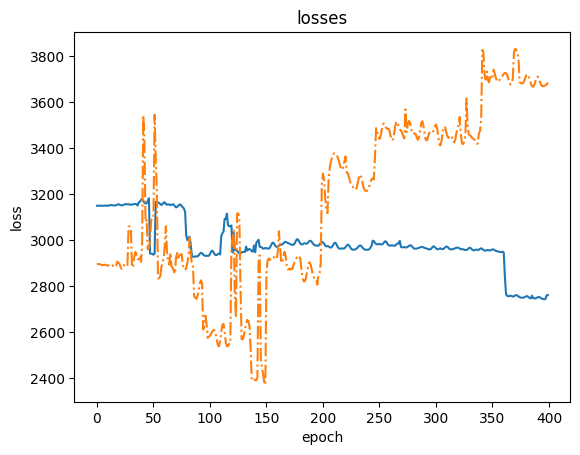

In [9]:
plt.plot(losses)
plt.plot(losses_val, '-.')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('losses')
plt.show()




# with torch.no_grad():
#     correct = 0
#     total = 0
#     for i, (labels, images) in enumerate(processed_data):
#         images = images.reshape((1, 4, 60, 80))
#         images = images.to(device)
#         labels = torch.tensor(labels, dtype=torch.float32)
#         labels = labels.to(device)
#         outputs = model(images)
#         print([labels[0], labels[1]], [outputs[0], outputs[1]])




In [12]:
video = ImageDataset(processed_data, processed_labels)

output = cv2.VideoWriter("osu_dl_video.avi",cv2.VideoWriter_fourcc(*'MPEG'),30, (1080, 1920))

model.eval()
for i, (images, labels) in enumerate(video):
    frame = images[0]
    images = images.to(device)
    # Move tensors to the configured device
    # images already got loaded on
    # images = images.to(device)
    output = model(images).numpy()
    
    frame = cv2.circle(frame,output,5, (0,0,255), -1) #draw circle
    output.write(frame)
    
output.release()
    
    
    

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x378 and 24192x128)